In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import seaborn as sns
from scipy import optimize
import time
import functools
from multiprocessing import Pool
#from cyipopt import minimize_ipopt
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import random

random.seed(10)


In [2]:
input_dir = r"/Users/juju/Library/Mobile Documents/com~apple~CloudDocs/ta_project/data"

In [3]:

data = pd.read_csv(os.path.join(input_dir,r"welfare_data_with_exante_ratings_update.csv"))

In [4]:
#Specify exante_rating

data["exante_rating"] = data["exante_rating_baseline"]
#data["exante_rating"] = data["exante_rating_random"]
#data["exante_rating"] = data["exante_rating_obs"]
#data["exante_rating"] = data["exante_rating_const"]

In [420]:

on_ta_param = 1.086
is_reviewed_param = -0.141
alpha = -0.01510385724693177
sigma = 0.5396
rating_param = 0.085

#occ_upper_1 = 85
#occ_upper_2 = 95
occ_upper=88

In [421]:
#add market size

market_size = data.groupby("Market")["Market Monthly Supply"].max().reset_index().rename(columns={"Market Monthly Supply":"market_size"})

data= data.merge(market_size, on="Market")

# Estimating marginal cost

In [422]:
df = data[data["year"]==2016].reset_index().drop(["index"],axis=1)
#df = data
# calculate the maximum price in the tier
max_group_price = df.groupby(["Market","year","month","Class Group"])["ADR"].max().reset_index().rename(columns={"ADR":"max_group_price"})
df = df.merge(max_group_price, on=["Market","year","month","Class Group"])


In [423]:
df.shape

(5597, 127)

In [424]:
df["mc_t"] = df["ADR"]+1/(alpha*(1/(1-sigma)-\
                                (sigma*df["group_share"]/(1-sigma))-\
                                df["market_share"]))
df["mc_t"] = df["mc_t"].clip(lower=0)

# calculate Occ=95% quantity
#df["q_upper_1"] = df["Supply"]*occ_upper_1/100
#df["q_upper_2"] = df["Supply"]*occ_upper_2/100

#df_lower = df[df["Demand"]<=df["q_upper_2"]]
#df_middle = df[(df["Demand"]>df["q_upper_1"])&(df["Demand"]<=df["q_upper_2"])]
#df_upper = df[df["Demand"]>df["q_upper_2"]]

#df_lower["excess_demand_1"] = 0
#df_lower["excess_demand_2"] = 0

#df_middle["excess_demand_1"] = df_middle["Demand"]-df_middle["q_upper_1"]
#df_middle["excess_demand_2"] = 0

#df_upper["excess_demand_1"] = df_upper["q_upper_2"]-df_upper["q_upper_1"]
#df_upper["excess_demand_2"] = df_upper["max_group_price"]*(df_upper["Demand"]-df_upper["q_upper_2"])


#df = pd.concat([df_lower,df_middle,df_upper],axis=0)
#df.index = df["index"]
#df = df.drop(["index"],axis=0)


df["q_upper"] = df["Supply"]*occ_upper/100

df_lower = df[df["Demand"]<=df["q_upper"]]
df_upper = df[df["Demand"]>df["q_upper"]]

df_lower["excess_demand"] =0
df_upper["excess_demand"] = df_upper["Demand"]-df_upper["q_upper"]
df = pd.concat([df_lower,df_upper],axis=0).reset_index()



/Users/juju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/juju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [425]:
# using competitors capacity as instruments
supply_max = data.groupby(["shareid","year"])["Supply"].max().reset_index().rename(columns={"Supply":"max_supply_year"})
df = df.merge(supply_max, on=["shareid","year"], how="left")
df["capacity"] = df["max_supply_year"]/30

In [426]:
class_capacity = df.groupby(["Market","year","month","Class Group"])["capacity"].sum().reset_index().rename(columns={"capacity":"class_group_capacity"})
hotel_count_group = df.groupby(["Market","year","month","Class Group"])["shareid"].nunique().reset_index().rename(columns={"shareid":"class_group_hotel_count"})                                                                                                           


df = df.merge(class_capacity, on= ["Market","year","month","Class Group"])
    
df["competitor_capacity"] = df["class_group_capacity"] - df["capacity"]




In [427]:
from statsmodels.api import add_constant
from linearmodels import IV2SLS
OH = OneHotEncoder(handle_unknown='ignore')

dep=df["mc_t"]

fe_var= ["shareid","market_year_month"]

x_fe = OH.fit_transform(df[fe_var]).toarray()
fe_var_cols = OH.fit(df[fe_var]).get_feature_names_out().tolist()
fe_var_df_1 = pd.DataFrame(x_fe, columns=fe_var_cols)
fe_var_df_1 = fe_var_df_1.drop([\
                                "shareid_75909",\
                               "market_year_month_2016-01-01Miami/Hialeah, FL",\
                                "market_year_month_2016-01-01Houston, TX",\
                               "market_year_month_2016-01-01Chicago, IL"], axis=1)

#endog_x=df[["excess_demand_1","excess_demand_2"]]
endog_x=df[["excess_demand"]]
endog = add_constant(endog_x)

exog = pd.concat([endog[["const"]],fe_var_df_1], axis=1).astype(float)

#df["ln_group_share"] = np.log(df["group_share"])

#from sklearn.preprocessing import StandardScaler
x =  df[["competitor_capacity",\
                "hotel_count_in_group_chain",
               "hotel_count_in_group_franchised",\
               "hotel_count_in_group_independent",\
               # "Group Avg Age",\
               '1_size','2_size','3_size','4_size']]
#x = add_constant(x)
instr = x.to_numpy()
#inst_var = statsmodels.tools.tools.add_constant(inst_var)
#scaler = StandardScaler().fit(inst_var)
#inst_var = scaler.transform(inst_var)

#model = IV2SLS(dep, exog, endog[["excess_demand_1","excess_demand_2"]], instr).fit(cov_type="unadjusted") 
model = IV2SLS(dep, exog, endog[["excess_demand"]], instr).fit(cov_type="unadjusted") 
model.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                   mc_t   R-squared:                      0.9369
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9304
No. Observations:                5597   F-statistic:                 8.355e+04
Date:                Thu, Jan 12 2023   P-value (F-stat)                0.0000
Time:                        07:14:13   Distribution:                chi2(523)
Cov. Estimator:            unadjusted                                         
                                                                              
                                               Parameter Estimates                                               
=================================================================================================================
                                               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------------------------------
const                                             193.15     11.302     17.091     0.0000      171.00      215.30
shareid_80022                                    -183.25     13.336    -13.741     0.0000     -209.39     -157.11
shareid_80596                                    -129.31     13.339    -9.6936     0.0000     -155.45     -103.16
shareid_80713                                    -28.387     12.864    -2.2067     0.0273     -53.600     -3.1741
shareid_81037                                    -3.3343     12.864    -0.2592     0.7955     -28.547      21.879
shareid_81154                                    -123.62     13.333    -9.2715     0.0000     -149.75     -97.483
shareid_81425                                    -1.4904     12.864    -0.1159     0.9078     -26.703      23.722
shareid_81685                                     76.496     12.864     5.9466     0.0000      51.284      101.71
shareid_81769                                    -69.707     13.339    -5.2257     0.0000     -95.852     -43.563
shareid_82026                                    -137.24     13.339    -10.289     0.0000     -163.39     -111.10
shareid_82381                                    -106.51     13.339    -7.9843     0.0000     -132.65     -80.361
shareid_82442                                     156.50     12.905     12.127     0.0000      131.21      181.79
shareid_82557                                     88.564     26.598     3.3297     0.0009      36.433      140.70
shareid_82658                                    -103.22     13.339    -7.7378     0.0000     -129.36     -77.073
shareid_83062                                    -70.093     13.672    -5.1266     0.0000     -96.890     -43.296
shareid_83265                                    -94.394     13.339    -7.0764     0.0000     -120.54     -68.250
shareid_83582                                    -97.715     13.339    -7.3253     0.0000     -123.86     -71.571
shareid_83784                                    -101.96     13.450    -7.5811     0.0000     -128.33     -75.604
shareid_84076                                    -120.59     13.339    -9.0402     0.0000     -146.74     -94.446
shareid_84172                                    -58.675     12.860    -4.5626     0.0000     -83.880     -33.470
shareid_84259                                     365.37     12.865     28.401     0.0000      340.15      390.58
shareid_84581                                    -109.45     13.587    -8.0554     0.0000     -136.08     -82.821
shareid_84600                                     18.569     12.864     1.4435     0.1489     -6.6440      43.782
shareid_84681                                    -166.02     13.339    -12.446     0.0000     -192.16     -139.87
shareid_84754                              

In [428]:
params = model.params.reset_index()
params_mc = dict(zip(params["index"],params["parameter"]))


In [429]:
#df["Market"].unique()

In [430]:

df["hotel_fixed_effect_id"] = 'shareid_'+df["shareid"].astype(str)
df["market_time_fixed_effect_id"] ='market_year_month_'+df["year_month"].astype(str)+df["Market"]

df["hotel_fixed_effect"] = [params_mc.get(i) for i in df["hotel_fixed_effect_id"]]
df["market_time_fixed_effect"] = [params_mc.get(i) for i in df["market_time_fixed_effect_id"]]


In [431]:
#df["mc"] = model.predict()["fitted_values"]

In [432]:
params_mc["const"]

193.15227555348247

In [433]:
params_mc["excess_demand"]

0.07102910584070266

In [434]:
#params_mc["excess_demand_2"]

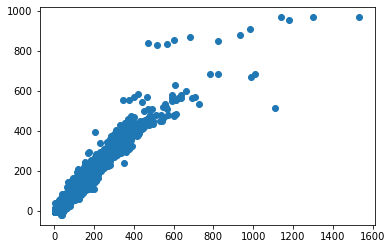

In [435]:
plt.scatter(df["mc_t"],model.predict()["fitted_values"])

In [436]:
df[df["hotel_fixed_effect"].isna()]

,index,post_month,shareid,year_month,Supply,Demand,Revenue,Occ,ADR,RevPAR,...,q_upper,excess_demand,max_supply_year,capacity,class_group_capacity,competitor_capacity,hotel_fixed_effect_id,market_time_fixed_effect_id,hotel_fixed_effect,market_time_fixed_effect
0,0,2016-08,75909,2016-08-01,2170.0,1464.0,209160.0,67.4654,142.868852,96.387097,...,1909.60,0.0,2170.0,72.333333,772.766667,700.433333,shareid_75909,"market_year_month_2016-08-01Miami/Hialeah, FL",NaN,-119.171771
6,6,2016-09,75909,2016-09-01,2100.0,700.0,75000.0,33.3333,107.142857,35.714286,...,1848.00,0.0,2170.0,72.333333,772.766667,700.433333,shareid_75909,"market_year_month_2016-09-01Miami/Hialeah, FL",NaN,-126.750674
12,12,2016-10,75909,2016-10-01,2170.0,1123.0,123965.0,51.7511,110.387355,57.126728,...,1909.60,0.0,2170.0,72.333333,772.766667,700.433333,shareid_75909,"market_year_month_2016-10-01Miami/Hialeah, FL",NaN,-103.914869
18,18,2016-11,75909,2016-11-01,1956.0,1282.0,201327.0,65.5419,157.041342,102.927914,...,1721.28,0.0,2170.0,72.333333,772.766667,700.433333,shareid_75909,"market_year_month_2016-11-01Miami/Hialeah, FL",NaN,-74.654989
24,24,2016-12,75909,2016-12-01,2003.0,1020.0,199453.0,50.9236,195.542157,99.577134,...,1762.64,0.0,2170.0,72.333333,772.766667,700.433333,shareid_75909,"market_year_month_2016-12-01Miami/Hialeah, FL",NaN,13.082637


In [437]:
OH = OneHotEncoder(handle_unknown='ignore')

x_1 =  pd.concat([x,exog], axis=1).astype(float)
res_first = sm.OLS(df.excess_demand, x_1).fit()
print(res_first.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_demand   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     9.534
Date:                Thu, 12 Jan 2023   Prob (F-statistic):               0.00
Time:                        07:14:23   Log-Likelihood:                -33371.
No. Observations:                5597   AIC:                         6.780e+04
Df Residuals:                    5066   BIC:                         7.132e+04
Df Model:                         530                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [438]:

x_2 = pd.concat([exog,res_first.fittedvalues], axis=1).astype(float)
res_ols = sm.OLS(dep,x_2).fit()
print(res_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   mc_t   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     155.7
Date:                Thu, 12 Jan 2023   Prob (F-statistic):               0.00
Time:                        07:14:25   Log-Likelihood:                -25544.
No. Observations:                5597   AIC:                         5.214e+04
Df Residuals:                    5073   BIC:                         5.561e+04
Df Model:                         523                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [373]:
from statsmodels.iolib.summary2 import summary_col
res_main = summary_col([res_ols,res_first], float_format = '%.3f', \
                  model_names = ["Second Stage","First Stage"],\
                 regressor_order = [0,\
                                     "hotel_count_in_group_chain",\
                                     "hotel_count_in_group_franchised",\
                                      "hotel_count_in_group_independent",\
                                    #"Group Avg Age",\
                                     '1_size',\
                                    '2_size',\
                                    '3_size',\
                                    '4_size',\
                                    "const"],
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                           'Adjusted R-squared':lambda x: "{:.2f}".format(x.rsquared_adj)},\
                  stars = True,drop_omitted=True)


beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}"""
endtex = "\end{document}"
output_dir = r"/Users/juju/Library/Mobile Documents/com~apple~CloudDocs/ta_project/output/demand"
f = open(os.path.join(output_dir,'mc_2.tex'), 'w')
f.write(beginningtex)
f.write(res_main.as_latex())
f.write(endtex)
f.close()

In [235]:
# calculate the maximum price in the tier
#max_group_price = df.groupby(["Market","year","month","Class Group"])["ADR"].max().reset_index().rename(columns={"ADR":"max_group_price"})
#df = df.merge(max_group_price, on=["Market","year","month","Class Group"])

In [236]:
# Occ is below average
#df_within_capacity = df[df["Occ"]<=df["avg_occ_year"]]
#c = df_within_capacity.groupby(["shareid","year"])["mc_t"].mean().reset_index().rename(columns={"mc_t":"c"})
#df = df.merge(c, on=["shareid","year"], how="left")

In [237]:
# Occ is above average but below 95
#df_out_capacity = df[(df["Occ"]>df["avg_occ_year"])&(df["Occ"]<=95)]
#df_out_capacity["excess_occ"] = df_out_capacity["Occ"]-df_out_capacity["avg_occ_year"]
#df_out_capacity["excess_occ"] = df_out_capacity["excess_occ"].clip(lower=0)
#df_out_capacity["excess_demand"] = df_out_capacity["excess_occ"]*df_out_capacity["capacity"]*30/100

#df_out_capacity["extra_cost"] = (df_out_capacity["mc_t"]-df_out_capacity["c"])/df_out_capacity["excess_demand"]
#c = df_out_capacity.groupby(["shareid","year","Market","Class Group"])["extra_cost"].mean().reset_index().rename(columns={"extra_cost":"extra_c"})
#c_group_mean = c.groupby(["year","Market","Class Group"])["extra_c"].mean().reset_index().rename(columns={"extra_c":"extra_c_group"})
#df =df.merge(c, on=["shareid","year","Market","Class Group"], how="left").merge(c_group_mean,on=["year","Market","Class Group"], how="left")
#df["extra_c"] = df["extra_c"].fillna(df["extra_c_group"])
#df["extra_c"] = df["extra_c"].clip(lower=0)

In [238]:
#df_2016.groupby("shareid")["Occ"].describe().reset_index()["mean"].mean()

In [239]:
#df_2016.groupby("shareid")["Occ"].describe().reset_index()["mean"].std()

In [240]:
#mean_price = df_2016.groupby("shareid")["ADR"].mean().reset_index().rename(columns = {"ADR":"mean_price_2016"})
#mean_occ = df_2016.groupby("shareid")["Occ"].mean().reset_index().rename(columns = {"Occ":"mean_occ_2016"})

In [241]:
#df_2016 = df_2016.merge(mean_price, on="shareid",how="left")\
  #      .merge(mean_occ, on="shareid",how="left")

In [242]:
#df_2016["deviation_from_mean_occ"] = (df_2016["Occ"]-df_2016["mean_occ_2016"])/df_2016["mean_occ_2016"]
#df_2016["deviation_from_mean_price"] = (df_2016["ADR"]-df_2016["mean_price_2016"])/df_2016["mean_price_2016"]

In [243]:
#df_2016

In [244]:
'''
class_groups = df_2016.groupby("Class Group")


for name, g in class_groups:
    
    x = g["deviation_from_mean_occ"]
    y = g["deviation_from_mean_price"]
    
    # Fit with polyfit
    b, m = polyfit(x, y, 1)

    plt.plot(x, y, '.')
    plt.plot(x, b + m * x, '-')
    plt.xlabel("monthly occ's % deviation from hotel's own mean occ in 2016")
    plt.ylabel("monthly ADR's % deviation from hotel's own mean price in 2016")
    plt.title(name)
    plt.show()
    
    '''

'\nclass_groups = df_2016.groupby("Class Group")\n\n\nfor name, g in class_groups:\n    \n    x = g["deviation_from_mean_occ"]\n    y = g["deviation_from_mean_price"]\n    \n    # Fit with polyfit\n    b, m = polyfit(x, y, 1)\n\n    plt.plot(x, y, \'.\')\n    plt.plot(x, b + m * x, \'-\')\n    plt.xlabel("monthly occ\'s % deviation from hotel\'s own mean occ in 2016")\n    plt.ylabel("monthly ADR\'s % deviation from hotel\'s own mean price in 2016")\n    plt.title(name)\n    plt.show()\n    \n    '

In [245]:
def moment_ne_share(r,data):
    # r is the vector of prices
    data["market_share_ne"]=r/10000
    within_group_share = data.groupby(["month","year","Class Group"])["market_share_ne"].sum().reset_index().rename(columns={"market_share_ne":"group_share_ne"})
    total_market_share =  data.groupby(["month","year"])["market_share_ne"].sum().reset_index().rename(columns={"market_share_ne":"market_share_sum_ne"})
    
    data = data.merge(within_group_share, on=["year","month","Class Group"], how="left")
    data = data.merge(total_market_share, on=["year","month"], how="left")
    data["s_0_ne"] = 1-data["market_share_sum_ne"] 
    
    
    
    data["delta_ne"] = np.log(data["market_share_ne"])-sigma*np.log(data["group_share_ne"])-np.log(data["s_0_ne"])
    data["price_ne"] = (data["delta_ne"]-data["quality"])/alpha
    
    data["mom_cond"] = data["price_ne"]-data["c"]+\
                                1/(alpha*(1/(1-sigma)-\
                                (sigma*data["group_share_ne"]/(1-sigma))-\
                                data["market_share_ne"]))
    
    
    return np.mean((data["mom_cond"])**2)


In [246]:
def moment_true_price(r,data):
    # r is the vector of prices
    
    data["delta_cf_ne"] = data["quality"]+alpha*r
    data["exp_delta_cf_over_1-sigma_ne"] = np.exp(data["delta_cf_ne"]/(1-sigma))

    
    D_g = data.groupby(["month","year","Class Group"])["exp_delta_cf_over_1-sigma_ne"].sum().reset_index().rename(columns={"exp_delta_cf_over_1-sigma_ne":"D_g_cf_ne"})
    D_g["D_g_1-sigma_cf_ne"] = D_g["D_g_cf_ne"]**(1-sigma)
    D_g["D_g_sigma_cf_ne"] = D_g["D_g_cf_ne"]**(sigma)
    D_g_sum = D_g.groupby(["month","year"])["D_g_1-sigma_cf_ne"].sum().reset_index().rename(columns={"D_g_1-sigma_cf_ne":"D_g_sum_cf_ne"})
    df_temp = data.merge(D_g, on=["month","year","Class Group"], how="left").\
         merge(D_g_sum, on=["month","year"], how="left")

    df_temp["market_share_cf_ne"] = df_temp["exp_delta_cf_over_1-sigma_ne"]/(df_temp["D_g_sigma_cf_ne"]*(df_temp["D_g_sum_cf_ne"]+1))
    
    df_temp["demand_cf_ne"] = df_temp["market_share_cf_ne"]*df_temp["market_size"]
    df_temp["occ_ne"] = (df_temp["demand_cf_ne"]*100/30)/df_temp["capacity"]
    
    df_temp_lower = df_temp[df_temp["demand_cf_ne"]<=df_temp["q_upper"]]
    #df_temp_middle = df_temp[(df_temp["demand_cf_ne"]>df_temp["q_upper_1"])&(df_temp["demand_cf_ne"]<=df_temp["q_upper_2"])]
    df_temp_upper = df_temp[df_temp["demand_cf_ne"]>df_temp["q_upper"]]

    df_temp_lower["excess_demand"] = 0
    #df_temp_lower["excess_demand_2"] = 0

    #df_temp_middle["excess_demand_1"] = df_temp_middle["demand_cf_ne"]-df_temp_middle["q_upper_1"]
    #df_temp_middle["excess_demand_2"] = 0

    #df_temp_upper["excess_demand_1"] = df_temp_upper["q_upper_2"]-df_temp_upper["q_upper_1"]
    df_temp_upper["excess_demand"] = df_temp_upper["demand_cf_ne"]-df_temp_upper["q_upper"]


    df_temp = pd.concat([df_temp_lower,df_temp_upper],axis=0)
    
    #df_temp_l["occ_greater_upper"] = df_temp["occ_ne"]>95
    #df_temp["excess_demand_ne"] = df_temp["demand_cf_ne"]-df_temp["q_upper"]
    #df_temp["excess_demand_interaction_ne"] = df_temp["excess_demand_ne"]*df_temp["occ_greater_upper"]
    data = df_temp.fillna(0)
    
    data["mc"] = 0.043841100663268406*data["excess_demand"]+\
                 192.39814102368837+data["hotel_fixed_effect"]+data["market_time_fixed_effect"]

    
    test = data.groupby(["month","year","Class Group"])["market_share_cf_ne"].sum().reset_index().rename(columns={"market_share_cf_ne":"group_share_cf_ne"})
    data = data.merge(test, on=["year","month","Class Group"], how="left")

    test_2 = data.groupby(["month","year"])["market_share_cf_ne"].sum().reset_index().rename(columns={"market_share_cf_ne":"market_share_sum_cf_ne"})
    data = data.merge(test_2, on=["year","month"], how="left")
    data["s_0_ne"] = 1-data["market_share_sum_cf_ne"]      

    df_2 = data.fillna(0)


    mom_cond = r-df_2["mc"]+\
                                1/(alpha*(1/(1-sigma)-\
                                (sigma*df_2["group_share_cf_ne"]/(1-sigma))-\
                                df_2["market_share_cf_ne"]))

    
    
    return np.mean((mom_cond)**2)
    #return df_2


In [247]:
def minimize(args):
    f,g = args
    res = optimize.minimize(f, x0 =g["ADR"] , args = (g), options={'disp': True})
    r = g[["Market","year","month"]]
    r["price_eq"] = res.x
    return r

In [248]:
class MyBounds(object):
    def __init__(self, xmax=[1,1], xmin=[0,0]):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)

    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin


In [249]:
#test =df[(df["Market"]=='Miami/Hialeah, FL')&(df["month"]==12)]
#test

In [250]:
groups = df.groupby(["Market","year","month"])

start = time.time()

l=[]
for name, g in groups:

    res = optimize.minimize(moment_true_price, args=(g), x0=g["ADR"], bounds = [(0,10000)]*len(g), options={'disp': True})
    g["price_ne"] = res.x
    l.append(g)    
    print("{}----{}----{}".format(*[name[0],name[1],name[2]]))



end = time.time()
print("--- %s seconds ---" % (end - start))

/Users/juju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/juju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.80179D+02    |proj g|=  1.44688D+00

At iterate    1    f=  4.63211D+02    |proj g|=  1.42096D+00

At iterate    2    f=  4.47354D+02    |proj g|=  1.04463D+00

At iterate    3    f=  3.55937D+02    |proj g|=  9.76070D-01

At iterate    4    f=  3.22384D+02    |proj g|=  2.52172D+00
  ys=-1.091E+00  -gs= 2.513E+01 BFGS update SKIPPED

At iterate    5    f=  3.20886D+02    |proj g|=  2.50347D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  3.20749D+02    |proj g|=  2.50031D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----1
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  111      7    101     10     1     0   2.500D+00   3.207D+02
  F =   320.74867635146774     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.12171D+02    |proj g|=  1.52465D+00

At iterate    1    f=  3.97643D+02    |proj g|=  1.49760D+00

At iterate    2    f=  3.54060D+02    |proj g|=  1.89774D+00

At iterate    3    f=  3.47431D+02    |proj g|=  1.99968D+00

At iterate    4    f=  3.47043D+02    |proj g|=  1.99798D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  3.04427D+02    |proj g|=  2.22422D+00

At iterate    6    f=  2.62947D+02    |proj g|=  1.71544D+00

At iterate    7    f=  2.57509D+02    |proj g|=  1.69551D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    8    f=  2.56992D+02    |proj g|=  1.68102D+00

At iterate    9    f=  2.56983D+02    |proj g|=  1.68091D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----2
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  111     10    174     14     0     0   1.681D+00   2.570D+02
  F =   256.98319181852429     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28325D+03    |proj g|=  7.79940D+00

At iterate    1    f=  1.26131D+03    |proj g|=  6.16094D+00

At iterate    2    f=  1.26023D+03    |proj g|=  6.09078D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Chicago, IL----2016----3
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  111      3     55      4     0     0   6.091D+00   1.260D+03
  F =   1260.2292281320874     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          112     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44275D+03    |proj g|=  2.41783D+01

At iterate    1    f=  1.02994D+03    |proj g|=  6.16138D+01

At iterate    2    f=  7.75400D+02    |proj g|=  2.54460D+01

At iterate    3    f=  7.62996D+02    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----4
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped

Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  112      8    127      9     1     0   2.277D+01   7.622D+02
  F =   762.15327910404335     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          112     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13957D+03    |proj g|=  2.57634D+01

At iterate    1    f=  1.49804D+03    |proj g|=  4.34293D+01

At iterate    2    f=  1.47635D+03    |proj g|=  2.39940D+01

At iterate    3    f=  1.28083D+03    |proj g|=  2.02496D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    4    f=  1.27971D+03    |proj g|=  2.02230D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----5

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  112      5     82      7     0     0   2.022D+01   1.280D+03
  F =   1279.7128300416157     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          113     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03811D+03    |proj g|=  1.01074D+02

At iterate    1    f=  3.99836D+03    |proj g|=  8.02312D+01

At iterate    2    f=  3.93525D+03    |proj g|=  5.88779D+01

At iterate    3    f=  3.93459D+03    |proj g|=  7.30576D+01

At iterate    4    f=  3.80756D+03    |proj g|=  3.62217D+01

At iterate    5    f=  3.80199D+03    |proj g|=  3.54809D+01

At iterate    6    f=  3.80194D+03    |proj g|=  3.54756D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    7    f=  3.31004D+03    |proj g|=  1.05558D+02

At iterate    8    f=  3.25135D+03    |proj g|=  1.44523D+02

At iterate    9    f=  3.24993D+03    |proj g|=  7.06687D+01

At iterate   10    f=  3.21565D+03    |proj g|=  6.27772D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   11    f=  3.21532D+03    |proj g|=  6.27137D+01

At iterate   12    f=  3.21531D+03    |proj g|=  6.27133D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----6
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  113     13    159     16     0     0   6.271D+01   3.215D+03
  F =   3215.3140123733051     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          113     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48516D+03    |proj g|=  5.41529D+01

At iterate    1    f=  3.46924D+03    |proj g|=  3.69420D+01

At iterate    2    f=  3.41544D+03    |proj g|=  6.36772D+01

At iterate    3    f=  3.39407D+03    |proj g|=  4.72918D+01

At iterate    4    f=  3.38378D+03    |proj g|=  4.30710D+01

At iterate    5    f=  2.05596D+03    |proj g|=  1.28170D+02

At iterate    6    f=  1.97907D+03    |proj g|=  1.06936D+02

At iterate    7    f=  1.95814D+03    |proj g|=  9.95560D+01

At iterate    8    f=  1.89066D+03    |proj g|=  7.15314D+01

At iterate    9    f=  1.81974D+03    |proj g|=  1.77398D+01

At iterate   10    f=  1.70455D+03    |proj g|=  1.40677D+01

At iterate   11    f=  1.53671D+03    |proj g|=  1.97598D+01

At iterate   12    f=  1.52874D+03    |proj g|=  1.95848D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   13    f=  1.51690D+03    |proj g|=  1.91365D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   14    f=  1.51662D+03    |proj g|=  1.91252D+01
Chicago, IL----2016----7
At iterate   15    f=  1.51661D+03    |proj g|=  1.91245D+01


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  113     15    140     17     0     0   1.912D+01   1.517D+03
  F =   1516.6077173535748     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80485D+03    |proj g|=  4.70864D+01

At iterate    1    f=  1.77351D+03    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----8
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  114      8     76      9     0     0   1.929D+01   1.228D+03
  F =   1228.2911510768033     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18967D+03    |proj g|=  4.32180D+01

At iterate    1    f=  3.06646D+03    |proj g|=  2.18714D+02

At iterate    2    f=  2.70617D+03    |proj g|=  3.51060D+01

At iterate    3    f=  2.58955D+03    |proj g|=  2.79040D+01

At iterate    4    f=  2.35398D+03    |proj g|=  3.00572D+01

At iterate    5    f=  2.29163D+03    |proj g|=  3.81293D+01

At iterate    6    f=  2.28943D+03    |proj g|=  3.80531D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----9
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  114      7     67      8     0     0   3.805D+01   2.289D+03
  F =   2289.4284668268670     

ABNORMAL_TERMINATION_IN_LNSRCH                              




 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          116     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44991D+03    |proj g|=  3.21157D+01

At iterate    1    f=  3.36293D+03    |proj g|=  6.82078D+01

At iterate    2    f=  3.04177D+03    |proj g|=  4.43096D+01

At iterate    3    f=  2.28573D+03    |proj g|=  1.29567D+02

At iterate    4    f=  2.00389D+03    |proj g|=  1.26848D+02

At iterate    5    f=  1.98854D+03    |proj g|=  1.17080D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  1.98839D+03    |proj g|=  1.16987D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----10
           * * *

Tit   = total number of iterations

Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  116      7    107      9     0     0   1.170D+02   1.988D+03
  F =   1988.3902372972884     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          119     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12389D+03    |proj g|=  3.25298D+01

At iterate    1    f=  1.91667D+03    |proj g|=  2.61627D+01

At iterate    2    f=  1.31341D+03    |proj g|=  1.01184D+02

At iterate    3    f=  6.82539D+02    |proj g|=  4.79123D+00

At iterate    4    f=  6.75588D+02    |proj g|=  4.35786D+00

At iterate    5    f=  6.75369D+02    |proj g|=  4.35027D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  119      6     73      7     0     0   4.350D+00   6.754D+02
  F =   675.36872370943979     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          118     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.40662D+02    |proj g|=  5.52830D+00

At iterate    1    f=  4.05067D+02    |proj g|=  8.08057D-01

At iterate    2    f=  3.54637D+02    |proj g|=  7.52572D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    3    f=  3.54591D+02    |proj g|=  7.52515D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----12
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  118      4     86      6     0     0   7.525D-01   3.546D+02
  F =   354.59097371994864     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          287     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00766D+03    |proj g|=  8.91998D+00

At iterate    1    f=  1.78352D+03    |proj g|=  9.13635D+00

At iterate    2    f=  1.35395D+03    |proj g|=  3.62340D+00

At iterate    3    f=  1.31415D+03    |proj g|=  4.17538D+00

At iterate    4    f=  1.26429D+03    |proj g|=  3.28478D+00

At iterate    5    f=  1.23831D+03    |proj g|=  2.84635D+00

At iterate    6    f=  1.20620D+03    |proj g|=  2.66418D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----1

At iterate    7    f=  1.20267D+03    |proj g|=  2.30841D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  287      7     64     11     0     0   2.308D+00   1.203D+03
  F =   1202.6681323031146     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          287     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94071D+03    |proj g|=  2.06368D+01

At iterate    1    f=  2.55288D+03    |proj g|=  8.09032D+00

At iterate    2    f=  2.46462D+03    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----3

At iterate    8    f=  1.93529D+03    |proj g|=  4.19684D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  286      8     63      9     0     0   4.197D+00   1.935D+03
  F =   1935.2891116279266     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          288     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00662D+03    |proj g|=  1.95289D+01

At iterate    1    f=  2.70669D+03    |proj g|=  3.49873D+01

At iterate    2    f=  2.55525D+03    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  1.36714D+03    |proj g|=  1.63050D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----5
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  289     11     91     13     0     0   1.630D+00   1.367D+03
  F =   1367.1414896483232     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          288     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26626D+03    |proj g|=  1.18292D+01

At iterate    1    f=  1.21273D+03    |proj g|=  1.78193D+01

At iterate    2    f=  1.16152D+03    |proj g|=  4.89993D+00

At iterate    3    f=  9.94246D+02    |proj g|=  5.24512D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    4    f=  9.82794D+02    |proj g|=  4.33256D+00

At iterate    5    f=  9.81383D+02    |proj g|=  4.30695D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----6
At iterate    6    f=  9.81377D+02    |proj g|=  4.30676D+00


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  288      6     86      8     0     0   4.307D+00   9.814D+02
  F =   981.37693810152814     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          291     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16449D+03    |proj g|=  1.16018D+01

At iterate    1    f=  1.11100D+03    |proj g|=  1.49885D+01

At iterate    2    f=  1.06973D+03    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----8

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  293      4     54     10     0     0   4.212D+00   1.213D+03
  F =   1212.7426140188757     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          295     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88506D+03    |proj g|=  8.90668D+00

At iterate    1    f=  1.73607D+03    |proj g|=  9.46907D+00
  ys=-3.071E+00  -gs= 1.464E+02 BFGS update SKIPPED

At iterate    2    f=  1.58910D+03    |proj g|=  8.30525D+00

At iterate    3    f=  1.40814D+03    |proj g|=  4.94547D+00

At iterate    4    f=  1.28127D+03    |proj g|=  8.12306D+00

At iterate    5    f=  1.25665D+03    |proj g|=  8.22558D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  1.24720D+03    |proj g|=  7.50347D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----9
At iterate    7    f=  1.24696D+03    |proj g|=  7.48587D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  295      7     82     12     1     0   7.486D+00   1.247D+03
  F =   1246.9605783554052     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          298     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41880D+03    |proj g|=  1.38034D+01

At iterate    1    f=  2.02830D+03    |proj g|=  1.51904D+01
  ys=-1.412E+01  -gs= 3.774E+02 BFGS update S


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    7    f=  1.32733D+03    |proj g|=  1.08088D+01
Houston, TX----2016----10
At iterate    8    f=  1.32584D+03    |proj g|=  1.06173D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  298      8     60     11     1     0   1.062D+01   1.326D+03
  F =   1325.8351136339177     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          299     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69382D+03    |proj g|=  6.23750D+00

At iterate    1    f=  1.63134D+03    |proj


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----11
At iterate    7    f=  1.17651D+03    |proj g|=  7.82370D+00


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  299      7     58      9     1     0   7.824D+00   1.177D+03
  F =   1176.5146029201160     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          298     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04563D+02    |proj g|=  4.77850D-01

At iterate    1    f=  1.03083D+02    |proj g|=  4.74658D-01

At iterate    2    f=  8.84346D+01    |proj


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----12
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations

Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  298      5     90      6     0     0   4.374D-01   8.773D+01
  F =   87.728556827191994     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           63     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.72648D+04    |proj g|=  7.00769D+01

At iterate    1    f=  4.96124D+04    |proj g|=  4.21269D+02

At iterate    2    f=  4.55230D+04    |proj g|=  1.59538D+02

At iterate    3    f=  4.52460D+04    |proj g|=  1.29674D+02

At iterate    4    f=  4.51876D+04    |proj g|=  1.24990D+02

At iterate    5    f=  4.51812D+04    |proj g|=  1.24583D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  4.51811D+04    |proj g|=  1.24566D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----1
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

   63      7    106      9     0     0   1.246D+02   4.518D+04
  F =   45181.083183418406     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           60     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29155D+04    |proj g|=  4.19808D+01

At iterate    1    f=  6.77981D+04    |proj g|=  8.38437D+01

At iterate    2    f=  6.61244D+04    |proj g|=  3.29390D+02

At iterate    3    f=  5.96246D+04    |proj g|=  1.38576D+02

At iterate    4    f=  5.95904D+04    |proj g|=  1.34757D+02

At iterate    5    f=  5.95891D+04    |proj g|=  1.34671D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  5.95891D+04    |proj g|=  1.34662D+02

At iterate    7    f=  5.95891D+04    |proj g|=  1.34668D+02
  ys=-2.752E-09  -gs= 2.961E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    8    f=  5.95891D+04    |proj g|=  1.34667D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----2
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

   60      9    157     12     1     0   1.347D+02   5.959D+04
  F =   59589.086129766059     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95806D+04    |proj g|=  1.42015D+02

At iterate    1    f=  5.91943D+04    |proj g|=  1.37326D+02

At iterate    2    f=  5.76606D+04    |proj g|=  9.32391D+01

At iterate    3    f=  5.72089D+04    |proj g|=  8.82573D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    4    f=  5.71536D+04    |proj g|=  8.87812D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  5.71526D+04    |proj g|=  8.87899D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----3
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

   61      6    139      9     0     0   8.879D+01   5.715D+04
  F =   57152.646372277923     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.33464D+04    |proj g|=  5.46853D+01

At iterate    1    f=  3.76397D+04    |proj g|=  1.38001D+02

At iterate    2    f=  3.74890D+04    |proj g|=  1.20426D+02

At iterate    3    f=  3.74721D+04    |proj g|=  1.19021D+02

At iterate    4    f=  3.74711D+04    |proj g|=  1.18959D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  3.74710D+04    |proj g|=  1.18957D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      6    124      8     0     0   1.190D+02   3.747D+04
  F =   37471.048584384829     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Miami/Hialeah, FL----2016----4
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.56843D+04    |proj g|=  3.20065D+01

At iterate    1    f=  1.93669D+04    |proj g|=  6.48502D+01

At iterate    2    f=  1.93146D+04    |proj g|=  6.36227D+01

At iterate    3    f=  1.93137D+04    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----5

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      6     74      7     0     0   9.288D+01   1.789D+04
  F =   17891.377609709827     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57217D+04    |proj g|=  1.61410D+01

At iterate    1    f=  1.56862D+04    |proj g|=  1.61217D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      2     51      3     0     0   1.612D+01   1.569D+04
  F =   15686.222720724458     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Miami/Hialeah, FL----2016----6
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63039D+04    |proj g|=  6.64425D+01

At iterate    1    f=  3.35708D+04    |proj g|=  4.52899D+01

At iterate    2    f=  2.96681D+04    |proj g|=  6.88459D+01

At iterate    3    f=  2.95644D+04    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  2.17040D+04    |proj g|=  7.99929D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Miami/Hialeah, FL----2016----7
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches

Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61     11    108     13     0     0   7.999D+01   2.170D+04
  F =   21703.953472177414     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           62     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44262D+04    |proj g|=  4.19739D+01

At iterate    1    f=  2.40891D+04    |proj g|=  3.00021D+01

At iterate    2    f=  2.01852D+04    |proj g|=  6.86675D+01

At iterate    3    f=  1.97108D+04    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----8
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   62      8     92      9     0     0   2.404D+01   1.941D+04
  F =   19411.813342391521     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78860D+04    |proj g|=  2.05273D+01

At iterate    1    f=  1.53915D+04    |proj g|=  3.67386D+01

At iterate    2    f=  1.52634D+04    |proj g|=  3.44718D+01

At iterate    3    f=  1.52579D+04    |proj g|=  3.44389D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    4    f=  1.52575D+04    |proj g|=  3.44023D+01

At iterate    5    f=  1.52575D+04    |proj g|=  3.44014D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----9
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

   61      6    132      8     0     0   3.440D+01   1.526D+04
  F =   15257.479653386859     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23972D+04    |proj g|=  1.94581D+01

At iterate    1    f=  1.93616D+04    |proj g|=  2.32925D+01

At iterate    2    f=  1.91326D+04    |proj g|=  7.09616D+01

At iterate    3    f=  1.87339D+04    |proj g|=  6.97968D+01

At iterate    4    f=  1.47688D+04    |proj g|=  8.65909D+01

At iterate    5    f=  1.47606D+04    |proj g|=  8.64463D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----10
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      6     69      7     0     0   8.645D+01   1.476D+04
  F =   14760.624913873588     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.11164D+04    |proj g|=  2.50657D+01

At iterate    1    f=  3.37101D+04    |proj g|=  6.67234D+01

At iterate    2    f=  3.35217D+04    |proj g|=  1.21675D+02

At iterate    3    f=  3.34613D+04    |proj g|=  1.22072D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    4    f=  3.08179D+04    |proj g|=  1.15322D+02

At iterate    5    f=  3.03518D+04    |proj g|=  4.17098D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  2.21855D+04    |proj g|=  5.09007D+01

At iterate    7    f=  2.21728D+04    |proj g|=  5.03445D+01

At iterate    8    f=  2.21726D+04    |proj g|=  5.03405D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----11
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      9    133     13     0     0   5.034D+01   2.217D+04
  F =   22172.571690796296     

ABNORMAL_TERMINATION_IN_LNSRCH                              




 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76791D+04    |proj g|=  9.87259D+01

At iterate    1    f=  7.29036D+04    |proj g|=  1.00597D+02

At iterate    2    f=  7.24537D+04    |proj g|=  9.94724D+01

At iterate    3    f=  7.12580D+04    |proj g|=  3.31986D+02

At iterate    4    f=  6.90669D+04    |proj g|=  1.46993D+02

At iterate    5    f=  6.65530D+04    |proj g|=  7.02391D+01

At iterate    6    f=  6.54156D+04    |proj g|=  5.03707D+01

At iterate    7    f=  6.39099D+04    |proj g|=  3.36051D+01

At iterate    8    f=  6.29435D+04    |proj g|=  3.35116D+01

At iterate    9    f=  5.63288D+04    |proj g|=  1.04668D+02

At iterate   10    f=  5.61106D+04    |proj g|=  9.31453D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   11    f=  5.60871D+04    |proj g|=  9.16523D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----12
--- 17998.141893148422 seconds ---
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *





 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61     12    118     14     0     0   9.165D+01   5.609D+04
  F =   56087.073170341544     

ABNORMAL_TERMINATION_IN_LNSRCH                              


In [252]:
res = pd.concat(l,axis=0)

data = res

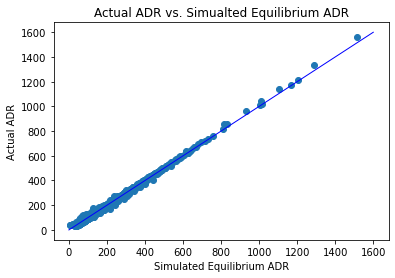

In [2]:
data = pd.read_csv(r"df_ne.csv")
plt.plot([0, 1600], [0, 1600], color = 'blue', linewidth = 1)
plt.xlabel("Simulated Equilibrium ADR")
plt.ylabel("Actual ADR")
plt.title("Actual ADR vs. Simualted Equilibrium ADR")

plt.scatter(data["price_ne"],data["ADR"])

In [254]:
#data_miami = pd.read_csv(r"miami_ne.csv")
#data = pd.concat([df_ne,data_miami],axis=0)

In [255]:
data = data.drop([
 'delta_cf_ne',
 'exp_delta_cf_over_1-sigma_ne'],axis=1)

In [256]:
data["delta"] = np.log(data["market_share"])-np.log(data["s_0"])-sigma*np.log(data["group_share"])

In [257]:
def calculate_market_share_ne(r,data):
    # r is the vector of prices
    
    data["delta_ne"] = data["delta"]-alpha*(data["ADR"]-r)
    data["exp_delta_cf_over_1-sigma_ne"] = np.exp(data["delta_ne"]/(1-sigma))

    
    D_g = data.groupby(["month","year","Class Group"])["exp_delta_cf_over_1-sigma_ne"].sum().reset_index().rename(columns={"exp_delta_cf_over_1-sigma_ne":"D_g_cf_ne"})
    D_g["D_g_1-sigma_cf_ne"] = D_g["D_g_cf_ne"]**(1-sigma)
    D_g["D_g_sigma_cf_ne"] = D_g["D_g_cf_ne"]**(sigma)
    D_g_sum = D_g.groupby(["month","year"])["D_g_1-sigma_cf_ne"].sum().reset_index().rename(columns={"D_g_1-sigma_cf_ne":"D_g_sum_ne"})
    df_temp = data.merge(D_g, on=["month","year","Class Group"], how="left").\
         merge(D_g_sum, on=["month","year"], how="left")

    df_temp["market_share_ne"] = df_temp["exp_delta_cf_over_1-sigma_ne"]/(df_temp["D_g_sigma_cf_ne"]*(df_temp["D_g_sum_ne"]+1))
    
    df_temp["demand_ne"] = df_temp["market_share_ne"]*df_temp["market_size"]
    data = df_temp.fillna(0)

    test = data.groupby(["month","year","Class Group"])["market_share_ne"].sum().reset_index().rename(columns={"market_share_ne":"group_share_ne"})
    data = data.merge(test, on=["year","month","Class Group"], how="left")

    test_2 = data.groupby(["month","year"])["market_share_ne"].sum().reset_index().rename(columns={"market_share_ne":"market_share_sum_ne"})
    data = data.merge(test_2, on=["year","month"], how="left")
    data["s_0_ne"] = 1-data["market_share_sum_ne"]      
    
    df_2 = data.fillna(0)
    
    df_2 = df_2.drop(["exp_delta_cf_over_1-sigma_ne",
                     "D_g_cf_ne",
                     "D_g_1-sigma_cf_ne",
                     "D_g_sigma_cf_ne"],axis=1)
    
    return df_2

In [258]:

groups = data.groupby(["Market","year","month"])

start = time.time()

l=[]
for name, g in groups:
    test_result = calculate_market_share_ne(g["price_ne"],g)
    l.append(test_result)


In [259]:

df_ne = pd.concat(l,axis=0)

In [260]:
df_ne.to_csv(r"df_ne.csv", index=False)

In [90]:
#df_ne = df_ne.drop(["exante_rating","quality_without_review_fixed_price"],axis=1)

In [ ]:
#df_eq = pd.read_csv(os.path.join(input_dir,r"welfare_eq_result.csv"))


In [966]:
#df_ne = df_eq.drop(["price_cf"],axis=1)

In [91]:
#df_ne=df_ne.merge(df[["shareid","year","month","exante_rating","quality_without_review_fixed_price"]], on=["shareid","month","year"])

In [92]:
#df_ne.to_csv(r"df_ne.csv", index=False)

In [538]:
#df_ne["market_share"].describe()

count    5623.000000
mean        0.004367
std         0.007201
min         0.000032
25%         0.001238
50%         0.002151
75%         0.005016
max         0.116672
Name: market_share, dtype: float64

Text(0, 0.5, 'Real price')

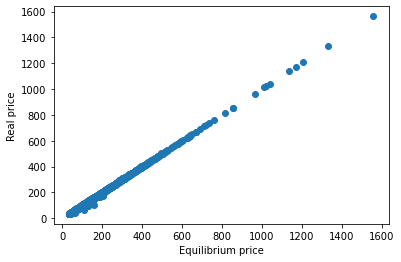

In [564]:


plt.scatter(df_ne["price_ne"],df_ne["ADR"])
plt.xlabel("Equilibrium price")
plt.ylabel("Real price")

Text(0.5, 1.0, 'Equilibrium vs. Actual Market Shares')

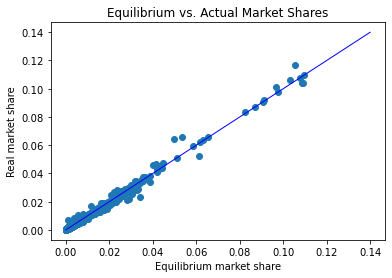

In [565]:
plt.scatter(df_ne["market_share_ne"],df_ne["market_share"])
plt.plot([0, 0.14], [0, 0.14], color = 'blue', linewidth = 1)
plt.xlabel("Equilibrium market share")
plt.ylabel("Real market share")
plt.title("Equilibrium vs. Actual Market Shares")

In [324]:
df_ne[df_ne["demand_ne"]>df_ne["Supply"]][["mc","price_ne","ADR"]]

,mc,price_ne,ADR
18,25.056423,56.766439,110.601509
43,53.746355,91.662479,134.272784
44,-18.998741,12.604760,69.299504
50,69.708545,107.459996,143.759540
55,65.745490,104.473500,146.385692
...,...,...,...
47,108.474942,144.365183,232.620278
51,391.251358,431.447526,460.011412
57,152.649719,187.657040,199.799344
13,512.572561,650.159147,1138.935860


In [568]:
def moment_cf_price(r,data):
    # r is the vector of prices
    
    data["delta_cf_ne"] = data["delta_ne"]-alpha*(data["price_ne"]-r)-rating_param*(data["Rating"] - data["exante_rating"])
    data["exp_delta_cf_over_1-sigma_ne"] = np.exp(data["delta_cf_ne"]/(1-sigma))

    
    D_g = data.groupby(["month","year","Class Group"])["exp_delta_cf_over_1-sigma_ne"].sum().reset_index().rename(columns={"exp_delta_cf_over_1-sigma_ne":"D_g_cf_ne"})
    D_g["D_g_1-sigma_cf_ne"] = D_g["D_g_cf_ne"]**(1-sigma)
    D_g["D_g_sigma_cf_ne"] = D_g["D_g_cf_ne"]**(sigma)
    D_g_sum = D_g.groupby(["month","year"])["D_g_1-sigma_cf_ne"].sum().reset_index().rename(columns={"D_g_1-sigma_cf_ne":"D_g_sum_cf_ne"})
    df_temp = data.merge(D_g, on=["month","year","Class Group"], how="left").\
         merge(D_g_sum, on=["month","year"], how="left")

    df_temp["market_share_cf_ne"] = df_temp["exp_delta_cf_over_1-sigma_ne"]/(df_temp["D_g_sigma_cf_ne"]*(df_temp["D_g_sum_cf_ne"]+1))
    
    df_temp["demand_cf_ne"] = df_temp["market_share_cf_ne"]*df_temp["market_size"]
    df_temp["occ_ne"] = (df_temp["demand_cf_ne"]*100/30)/df_temp["capacity"]
    

    df_temp_lower = df_temp[df_temp["demand_cf_ne"]<=df_temp["q_upper_1"]]
    df_temp_middle = df_temp[(df_temp["demand_cf_ne"]>df_temp["q_upper_1"])&(df_temp["demand_cf_ne"]<=df_temp["q_upper_2"])]
    df_temp_upper = df_temp[df_temp["demand_cf_ne"]>df_temp["q_upper_2"]]

    
    data = df_temp.fillna(0)
    
    df_temp_lower["excess_demand_1"] = 0
    df_temp_lower["excess_demand_2"] = 0

    df_temp_middle["excess_demand_1"] = df_temp_middle["demand_cf_ne"]-df_temp_middle["q_upper_1"]
    df_temp_middle["excess_demand_2"] = 0

    df_temp_upper["excess_demand_1"] = df_temp_upper["q_upper_2"]-df_temp_upper["q_upper_1"]
    df_temp_upper["excess_demand_2"] = df_temp_upper["max_group_price"]*(df_temp_upper["demand_cf_ne"]-df_temp_upper["q_upper_2"])


    df_temp = pd.concat([df_temp_lower,df_temp_middle,df_temp_upper],axis=0)
    
    '''
    data_within_capacity = data[data["occ_ne"]<=data["avg_occ_year"]]
    if data_within_capacity.empty is True:
        pass
    else:
        data_within_capacity["mc"] = data_within_capacity["c"]

    data_out_capacity = data[(data["occ_ne"]>data["avg_occ_year"])&(data["occ_ne"]<=95)]
    if data_out_capacity.empty is True:
        pass
    else:
        data_out_capacity["mc"] = data_out_capacity["c"]+\
                                  data_out_capacity["extra_c"]*30*data_out_capacity["capacity"]*(data_out_capacity["occ_ne"]-data_out_capacity["avg_occ_year"])*0.01

    data_exceed_capacity = data[data["occ_ne"]>95]
    if data_exceed_capacity is True:
        pass
    else:
        data_exceed_capacity["mc"] = data_exceed_capacity["c"]+\
                                 data_exceed_capacity["extra_c"]*30*data_exceed_capacity["capacity"]*(95-data_exceed_capacity["avg_occ_year"])*0.01+\
                                 data_exceed_capacity["max_group_price"]*30*data_exceed_capacity["capacity"]*(data_exceed_capacity["occ_ne"]-95)*0.01

    data = pd.concat([data_within_capacity,data_out_capacity, data_exceed_capacity],axis=0,ignore_index=True)
    '''
    
    data = df_temp.fillna(0)
    
    data["mc"] = 0.056232584409855235*data["excess_demand_1"]+\
                 -0.0007989832794415008*data["excess_demand_2"]+\
                 192.30981914412405+data["hotel_fixed_effect"]+data["market_time_fixed_effect"]

    
    test = data.groupby(["month","year","Class Group"])["market_share_cf_ne"].sum().reset_index().rename(columns={"market_share_cf_ne":"group_share_cf_ne"})
    data = data.merge(test, on=["year","month","Class Group"], how="left")

    test_2 = data.groupby(["month","year"])["market_share_cf_ne"].sum().reset_index().rename(columns={"market_share_cf_ne":"market_share_sum_cf_ne"})
    data = data.merge(test_2, on=["year","month"], how="left")
    data["s_0_ne"] = 1-data["market_share_sum_cf_ne"]      

    df_2 = data.fillna(0)


    mom_cond = r-df_2["mc"]+\
                                1/(alpha*(1/(1-sigma)-\
                                (sigma*df_2["group_share_cf_ne"]/(1-sigma))-\
                                df_2["market_share_cf_ne"]))

    
    
    return np.mean((mom_cond)**2)


In [569]:
groups = df_ne.groupby(["Market","year","month"])

start = time.time()

l=[]
for name, g in groups:

    res = optimize.minimize(moment_cf_price, args=(g), x0=g["ADR"], bounds = [(0,10000)]*len(g),options={'disp': True})
    g["price_cf"] = res.x
    l.append(g)    
    print("{}----{}----{}".format(*[name[0],name[1],name[2]]))



end = time.time()
print("--- %s seconds ---" % (end - start))

/Users/juju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/juju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/juju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.63637D+02    |proj g|=  1.11119D+01

At iterate    1    f=  5.35577D+02    |proj g|=  5.31580D+00

At iterate    2    f=  4.73081D+02    |proj g|=  1.01157D+00

At iterate    3    f=  3.69395D+02    |proj g|=  9.30203D-01


/Users/juju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/juju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



At iterate    4    f=  3.65430D+02    |proj g|=  9.26133D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  3.65361D+02    |proj g|=  9.26048D-01

At iterate    6    f=  3.65358D+02    |proj g|=  9.26048D-01

At iterate    7    f=  3.65358D+02    |proj g|=  9.26025D-01
  ys=-9.421E-11  -gs= 2.590E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----1
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  111      8    124     10     1     0   9.260D-01   3.654D+02
  F =   365.35838204884834     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00684D+02    |proj g|=  1.29673D+01

At iterate    1    f=  4.74413D+02    |proj g|=  7.30637D+00

At iterate    2    f=  4.05554D+02    |proj g|=  1.01106D+00

At iterate    3    f=  3.26440D+02    |proj g|=  8.74844D-01

At iterate    4    f=  3.25485D+02    |proj g|=  8.73297D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  3.25431D+02    |proj g|=  8.73178D-01

At iterate    6    f=  3.25426D+02    |proj g|=  8.73184D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----2
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point

Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  111      7    104      9     0     0   8.732D-01   3.254D+02
  F =   325.42595108162072     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21429D+03    |proj g|=  5.86137D+01

At iterate    1    f=  1.95573D+03    |proj g|=  2.26974D+01

At iterate    2    f=  1.00699D+03    |proj g|=  1.16060D+01

At iterate    3    f=  1.00502D+03    |proj g|=  1.12406D+01

At iterate    4    f=  1.00497D+03    |proj g|=  1.12329D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  8.03705D+02    |proj g|=  8.91607D+01

At iterate    6    f=  7.92410D+02    |proj g|=  7.58556D+01

At iterate    7    f=  7.70660D+02    |proj g|=  4.68549D+01

At iterate    8    f=  7.65745D+02    |proj g|=  3.98807D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    9    f=  5.85253D+02    |proj g|=  1.14202D+01

At iterate   10    f=  5.82324D+02    |proj g|=  9.54487D+00

At iterate   11    f=  5.77120D+02    |proj g|=  5.91767D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   12    f=  5.75859D+02    |proj g|=  4.72577D+00
Chicago, IL----2016----3
At iterate   13    f=  5.75793D+02    |proj g|=  4.68063D+00


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  111     13    147     16     0     0   4.681D+00   5.758D+02
  F =   575.79321870333627     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          112     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44786D+03    |proj g|=  2.23587D+02

At iterate    1    f=  3.14643D+03    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    8    f=  3.06502D+03    |proj g|=  5.03946D+01

At iterate    9    f=  3.06500D+03    |proj g|=  5.03932D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----4
At iterate   10    f=  3.06500D+03    |proj g|=  5.03935D+01


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  112     10    162     12     0     0   5.039D+01   3.065D+03
  F =   3064.9968791391429     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          112     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16610D+03    |proj g|=  3.51808D+02

At iterate    1    f=  2.91923D+03    |proj g|=  6.92083D+01

At iterate    2    f=  2.45789D+03    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  2.28569D+03    |proj g|=  8.82557D+01

At iterate    6    f=  2.11821D+03    |proj g|=  1.15338D+02

At iterate    7    f=  2.11558D+03    |proj g|=  1.14104D+02

At iterate    8    f=  2.02340D+03    |proj g|=  7.22571D+01

At iterate    9    f=  2.01966D+03    |proj g|=  6.99932D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  2.01929D+03    |proj g|=  6.97167D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----5

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  112     11    157     14     0     0   6.972D+01   2.019D+03
  F =   2019.2855069342611     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          113     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13726D+03    |proj g|=  4.69127D+02

At iterate    1    f=  5.80190D+03    |proj g|=  3.88050D+02

At iterate    2    f=  5.30513D+03    |proj g|=  4.58736D+02

At iterate    3    f=  5.03720D+03    |proj g|=  2.35086D+02

At iterate    4    f=  4.92316D+03    |proj g|=  2.31863D+02

At iterate    5    f=  4.84029D+03    |proj g|=  2.26449D+02

At iterate    6    f=  4.83653D+03    |proj g|=  2.26170D+02

At iterate    7    f=  4.83631D+03    |proj g|=  2.26153D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----6
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  113      8     91      9     0     0   2.262D+02   4.836D+03
  F =   4836.3086970573222     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          113     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11093D+03    |proj g|=  2.92306D+02

At iterate    1    f=  2.84418D+03    |proj g|=  2.49310D+02

At iterate    2    f=  2.43695D+03    |proj g|=  9.52758D+01

At iterate    3    f=  2.40729D+03    |proj g|=  1.15162D+02

At iterate    4    f=  2.40582D+03    |proj g|=  1.15043D+02

At iterate    5    f=  2.40566D+03    |proj g|=  1.15027D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  2.26839D+03    |proj g|=  1.16642D+02

At iterate    7    f=  2.24086D+03    |proj g|=  1.10547D+02

At iterate    8    f=  2.24076D+03    |proj g|=  1.10534D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    9    f=  2.24076D+03    |proj g|=  1.10528D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----7

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  113     10    147     14     0     0   1.105D+02   2.241D+03
  F =   2240.7610018025321     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08173D+03    |proj g|=  1.43820D+02

At iterate    1    f=  2.97874D+03    |proj g|=  1.24697D+02

At iterate    2    f=  2.40518D+03    |proj g|=  1.36916D+02

At iterate    3    f=  2.14891D+03    |proj g|=  7.47499D+01

At iterate    4    f=  2.13249D+03    |proj g|=  6.94017D+01

At iterate    5    f=  2.11030D+03    |proj g|=  3.54598D+01

At iterate    6    f=  2.04510D+03    |proj g|=  8.52688D+01

At iterate    7    f=  2.03334D+03    |proj g|=  7.94883D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    8    f=  2.02589D+03    |proj g|=  7.47783D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----8

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  114      9    108     12     0     0   7.478D+01   2.026D+03
  F =   2025.8944765365384     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60552D+03    |proj g|=  2.98495D+02

At iterate    1    f=  3.32400D+03    |proj g|=  8.04328D+01

At iterate    2    f=  3.29505D+03    |proj g|=  7.67165D+01

At iterate    3    f=  3.24704D+03    |proj g|=  6.95171D+01

At iterate    4    f=  3.23833D+03    |proj g|=  6.83039D+01

At iterate    5    f=  3.19991D+03    |proj g|=  8.15607D+01

At iterate    6    f=  3.18768D+03    |proj g|=  7.93649D+01

At iterate    7    f=  3.18742D+03    |proj g|=  7.93289D+01

At iterate    8    f=  3.18741D+03    |proj g|=  7.93283D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    9    f=  3.04615D+03    |proj g|=  9.29284D+01

At iterate   10    f=  3.04253D+03    |proj g|=  9.18229D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   11    f=  3.01383D+03    |proj g|=  7.92410D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----9
At iterate   12    f=  3.01258D+03    |proj g|=  7.87217D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches

Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  114     12    164     15     0     0   7.872D+01   3.013D+03
  F =   3012.5810589766120     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          116     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.63224D+03    |proj g|=  2.05617D+02

At iterate    1    f=  5.04029D+03    |proj g|=  2.44361D+02

At iterate    2    f=  4.70743D+03    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----10
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  116      8     97      9     0     0   1.478D+02   4.374D+03
  F =   4373.7770787998361     

ABNORMAL_TERMINATION_IN_LNSRCH                              




 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          119     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27949D+03    |proj g|=  3.96712D+01

At iterate    1    f=  1.71099D+03    |proj g|=  1.37026D+02

At iterate    2    f=  1.69028D+03    |proj g|=  8.04728D+01

At iterate    3    f=  1.53934D+03    |proj g|=  2.80455D+01

At iterate    4    f=  1.35920D+03    |proj g|=  3.42902D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.27637D+03    |proj g|=  3.23944D+01

At iterate    6    f=  1.27598D+03    |proj g|=  3.23225D+01

At iterate    7    f=  1.25352D+03    |proj g|=  2.82931D+01

At iterate    8    f=  1.17612D+03    |proj g|=  1.68023D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    9    f=  1.17606D+03    |proj g|=  1.67984D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----11
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  119     10    152     13     0     0   1.680D+01   1.176D+03
  F =   1176.0643354629542     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          118     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04620D+03    |proj g|=  4.43129D+01

At iterate    1    f=  5.41540D+02    |proj g|=  1.34322D+01

At iterate    2    f=  5.35936D+02    |proj g|=  1.25085D+00

At iterate    3    f=  5.08075D+02    |proj g|=  8.54626D+00

At iterate    4    f=  4.25526D+02    |proj g|=  1.24155D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  4.22638D+02    |proj g|=  9.70162D+00

At iterate    6    f=  4.08367D+02    |proj g|=  6.49951D+00

At iterate    7    f=  4.05380D+02    |proj g|=  7.51297D+00

At iterate    8    f=  4.03985D+02    |proj g|=  7.39807D+00

At iterate    9    f=  4.03941D+02    |proj g|=  7.39356D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Chicago, IL----2016----12
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value


           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  118     10    118     12     0     0   7.394D+00   4.039D+02
  F =   403.94147405743104     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          287     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58573D+03    |proj g|=  1.02975D+01

At iterate    1    f=  2.56229D+03    |proj g|=  1.97173D+01

At iterate    2    f=  2.55595D+03    |proj g|=  2.09333D+01

At iterate    3    f=  2.54290D+03    |proj


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----1
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  287      8     66      9     0     0   2.220D+01   2.518D+03
  F =   2518.4590777538037     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          287     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21902D+03    |proj g|=  4.77995D+01

At iterate    1    f=  3.14448D+03    |proj g|=  6.79541D+01

At iterate    2    f=  2.89183D+03    |proj g|=  2.32900D+01

At iterate    3    f=  2.81238D+03    |proj g|=  3.88550D+01

At iterate    4    f=  2.80459D+03    |proj g|=  3.80956D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----2
At iterate    5    f=  2.80458D+03    |proj g|=  3.80933D+01


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  287      5     57      6     0     0   3.809D+01   2.805D+03
  F =   2804.5781798828170     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          286     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85179D+03    |proj g|=  6.57792D+01

At iterate    1    f=  2.65365D+03    |proj g|=  9.16226D+01

At iterate    2    f=  2.30762D+03    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----3
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  286      6     89      7     0     0   1.366D+01   2.293D+03
  F =   2293.0019503905096     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          288     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72671D+03    |proj g|=  3.02127D+01

At iterate    1    f=  2.59847D+03    |proj g|=  6.24591D+01

At iterate    2    f=  2.54475D+03    |proj g|=  7.21274D+01

At iterate    3    f=  2.48166D+03    |proj g|=  5.21671D+01

At iterate    4    f=  2.47927D+03    |proj g|=  2.83885D+01

At iterate    5    f=  2.45745D+03    |proj g|=  5.63911D+01

At iterate    6    f=  2.44737D+03    |proj g|=  5.59412D+01

At iterate    7    f=  2.44708D+03    |proj g|=  5.59384D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----4
At iterate    8    f=  2.44680D+03    |proj g|=  5.58387D+01


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  288      8     75      9     0     0   5.584D+01   2.447D+03
  F =   2446.7991735261649     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          289     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32837D+03    |proj g|=  4.62306D+01

At iterate    1    f=  2.30511D+03    |proj g|=  8.36443D+01

At iterate    2    f=  2.18985D+03    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----5
At iterate    4    f=  2.18159D+03    |proj g|=  1.77111D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches

Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  289      4     59      5     0     0   1.771D+01   2.182D+03
  F =   2181.5876235855844     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          288     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01583D+03    |proj g|=  2.92965D+01

At iterate    1    f=  1.99051D+03    |proj g|=  9.52978D+00

At iterate    2    f=  1.99035D+03    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Houston, TX----2016----6
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  288      3     63      4     0     0   9.514D+00   1.990D+03
  F =   1990.3548813260079     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          291     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79055D+03    |proj g|=  1.29098D+01

At iterate    1    f=  1.76087D+03    |proj g|=  2.58288D+01

At iterate    2    f=  1.76070D+03    |proj g|=  1.08056D+01

At iterate    3    f=  1.75707D+03    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  1.73010D+03    |proj g|=  2.61295D+01

At iterate    7    f=  1.72832D+03    |proj g|=  2.51395D+01
Houston, TX----2016----7
At iterate    8    f=  1.72824D+03    |proj g|=  2.51033D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped

Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  291      8     67      9     0     0   2.510D+01   1.728D+03
  F =   1728.2444340667059     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          293     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.38329D+03    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----8

At iterate    5    f=  2.24197D+03    |proj g|=  1.60621D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  293      5     64      6     0     0   1.606D+01   2.242D+03
  F =   2241.9655600252318     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          295     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39565D+03    |proj g|=  2.32897D+01

At iterate    1    f=  2.35897D+03    |proj g|=  2.70397D+01

At iterate    2    f=  2.34000D+03    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----11
At iterate    5    f=  6.99440D+02    |proj g|=  6.04606D+00


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  299      5     58      9     0     0   6.046D+00   6.994D+02
  F =   699.43989122973892     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          298     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11321D+02    |proj g|=  4.71720D-01

At iterate    1    f=  1.09740D+02    |proj g|=  4.68557D-01

At iterate    2    f=  9.38174D+01    |proj


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Houston, TX----2016----12
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  298      4     73      5     0     0   4.329D-01   9.379D+01
  F =   93.788754579878699     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           63     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.90521D+04    |proj g|=  6.52544D+02

At iterate    1    f=  5.65340D+04    |proj g|=  1.99903D+02

At iterate    2    f=  5.62710D+04    |proj g|=  2.87566D+02

At iterate    3    f=  5.49725D+04    |proj


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    7    f=  5.25947D+04    |proj g|=  2.44568D+02

At iterate    8    f=  5.22871D+04    |proj g|=  2.89289D+02

At iterate    9    f=  5.21073D+04    |proj g|=  2.75456D+02

At iterate   10    f=  5.18245D+04    |proj g|=  2.53577D+02

At iterate   11    f=  5.18105D+04    |proj g|=  2.52735D+02

At iterate   12    f=  5.18101D+04    |proj g|=  2.52717D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   13    f=  5.18100D+04    |proj g|=  2.52712D+02
  ys=-1.235E-07  -gs= 5.292E-02 BFGS update SKIPPED

At iterate   14    f=  5.18100D+04    |proj g|=  2.52711D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----1

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   63     15    202     19     1     0   2.527D+02   5.181D+04
  F =   51810.031433569078     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           60     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.33888D+04    |proj g|=  6.08913D+02

At iterate    1    f=  5.17615D+04    |proj g|=  4.59115D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----2
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

   60      2     49      3     0     0   4.591D+02   5.176D+04
  F =   51761.520153103600     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.06071D+04    |proj g|=  6.23933D+02

At iterate    1    f=  4.66769D+04    |proj g|=  2.63529D+02

At iterate    2    f=  4.63143D+04    |proj g|=  2.94775D+02

At iterate    3    f=  4.60662D+04    |proj g|=  2.98096D+02

At iterate    4    f=  4.60197D+04    |proj g|=  2.97690D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  4.06405D+04    |proj g|=  3.86138D+02

At iterate    6    f=  4.05311D+04    |proj g|=  3.78995D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Miami/Hialeah, FL----2016----3
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations

Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      7    106     10     0     0   3.790D+02   4.053D+04
  F =   40531.125582361521     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81999D+04    |proj g|=  2.83694D+02

At iterate    1    f=  3.78383D+04    |proj g|=  1.87962D+02

At iterate    2    f=  3.74390D+04    |proj g|=  1.58879D+02

At iterate    3    f=  3.73741D+04    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----4
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

   61      5     85      6     0     0   1.558D+02   3.737D+04
  F =   37371.684924493522     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52778D+04    |proj g|=  4.35109D+01

At iterate    1    f=  3.52237D+04    |proj g|=  4.32512D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----5
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

   61      2     54      3     0     0   4.325D+01   3.522D+04
  F =   35223.727149502673     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40793D+04    |proj g|=  4.75713D+01

At iterate    1    f=  1.74070D+04    |proj g|=  1.31716D+02

At iterate    2    f=  1.63690D+04    |proj g|=  8.63748D+01

At iterate    3    f=  1.62640D+04    |proj g|=  7.60748D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Miami/Hialeah, FL----2016----6
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      4     53      5     0     0   7.607D+01   1.626D+04
  F =   16263.969405533786     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48415D+04    |proj g|=  1.70745D+02

At iterate    1    f=  3.45432D+04    |proj g|=  1.59784D+02

At iterate    2    f=  3.45079D+04    |proj g|=  1.58438D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----7
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      3     63      4     0     0   1.584D+02   3.451D+04
  F =   34507.912721782632     

ABNORMAL_TERMINATION_IN_LNSRCH                              




 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           62     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52619D+04    |proj g|=  5.92285D+01

At iterate    1    f=  2.51513D+04    |proj g|=  5.43536D+01

At iterate    2    f=  2.51442D+04    |proj g|=  5.40797D+01

At iterate    3    f=  2.51438D+04    |proj g|=  5.40709D+01

At iterate    4    f=  2.48339D+04    |proj g|=  6.54880D+01

At iterate    5    f=  2.47902D+04    |proj g|=  9.95739D+01

At iterate    6    f=  2.47858D+04    |proj g|=  9.93808D+01

At iterate    7    f=  2.43533D+04    |proj g|=  8.57998D+02

At iterate    8    f=  2.29141D+04    |proj g|=  1.07570D+02

At iterate    9    f=  2.28493D+04    |proj g|=  9.83883D+01

At iterate   10    f=  2.28325D+04    |proj g|=  9.59578D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
Miami/Hialeah, FL----2016----8
   62     11    129     12     0     0   9.596D+01   2.283D+04
  F =   22832.457070970373     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49233D+04    |proj g|=  1.08928D+02

At iterate    1    f=  1.47704D+04    |proj g|=  1.95723D+01

At iterate    2    f=  1.46433D+04    |proj g|=  9.84227D+01

At iterate    3    f=  1.46176D+04    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    4    f=  1.46164D+04    |proj g|=  1.87923D+01

At iterate    5    f=  1.46163D+04    |proj g|=  1.87920D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  1.46163D+04    |proj g|=  1.87920D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----9
At iterate    7    f=  1.46163D+04    |proj g|=  1.87916D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      7    134     10     0     0   1.879D+01   1.462D+04
  F =   14616.270788022321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60014D+04    |proj g|=  1.63677D+02

At iterate    1    f=  1.55761D+04    |proj g|=  1.31710D+02

At iterate    2    f=  1.55316D+04    |proj g|=  2.42730D+01

At iterate    3    f=  1.54298D+04    |proj g|=  2.46808D+01
  ys=-2.996E-01  -gs= 1.016E+02 BFGS update SKIPPED

At iterate    4    f=  1.54278D+04    |proj g|=  2.46882D+01
  ys=-9.650E-05  -gs= 2.074E+00 BFGS update SKIPPED

At iterate    5    f=  1.54277D+04    |proj g|=  2.46884D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Miami/Hialeah, FL----2016----10
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

   61      6     81      7     2     0   2.469D+01   1.543D+04
  F =   15427.748499699330     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04668D+04    |proj g|=  1.81078D+02

At iterate    1    f=  3.47892D+04    |proj g|=  5.37238D+02

At iterate    2    f=  3.45761D+04    |proj g|=  5.02534D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      3     60      4     0     0   5.025D+02   3.458D+04
  F =   34576.076053485260     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.80994D+04    |proj g|=  1.12949D+02

At iterate    1    f=  7.58751D+04    |proj g|=  1.32449D+02

At iterate    2    f=  7.56999D+04    |proj g|=  1.35158D+02
  ys=-1.775E+00  -gs= 1.743E+02 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----12
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations

--- 27118.934370994568 seconds ---



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      3     54      4     1     0   1.352D+02   7.570D+04
  F =   75699.915692986207     

ABNORMAL_TERMINATION_IN_LNSRCH                              


In [570]:
# add iterations print
res_cf = pd.concat(l,axis=0)
data_cf = res_cf

In [571]:
data_cf = data_cf.drop(['delta_cf_ne',
 'exp_delta_cf_over_1-sigma_ne'],axis=1)

In [572]:
def calculate_market_share_cf(r,data):
    # r is the vector of prices
    
    data["delta_cf"] = data["delta_ne"]-alpha*(data["price_ne"]-r)-rating_param*(data["Rating"] - data["exante_rating"])
    data["exp_delta_cf_over_1-sigma_ne"] = np.exp(data["delta_cf"]/(1-sigma))

    
    D_g = data.groupby(["month","year","Class Group"])["exp_delta_cf_over_1-sigma_ne"].sum().reset_index().rename(columns={"exp_delta_cf_over_1-sigma_ne":"D_g_cf_ne"})
    D_g["D_g_1-sigma_cf_ne"] = D_g["D_g_cf_ne"]**(1-sigma)
    D_g["D_g_sigma_cf_ne"] = D_g["D_g_cf_ne"]**(sigma)
    D_g_sum = D_g.groupby(["month","year"])["D_g_1-sigma_cf_ne"].sum().reset_index().rename(columns={"D_g_1-sigma_cf_ne":"D_g_sum_cf"})
    df_temp = data.merge(D_g, on=["month","year","Class Group"], how="left").\
         merge(D_g_sum, on=["month","year"], how="left")

    df_temp["market_share_cf"] = df_temp["exp_delta_cf_over_1-sigma_ne"]/(df_temp["D_g_sigma_cf_ne"]*(df_temp["D_g_sum_cf"]+1))
    
    df_temp["demand_cf"] = df_temp["market_share_cf"]*df_temp["market_size"]
    data = df_temp.fillna(0)

    test = data.groupby(["month","year","Class Group"])["market_share_cf"].sum().reset_index().rename(columns={"market_share_cf":"group_share_cf"})
    data = data.merge(test, on=["year","month","Class Group"], how="left")

    test_2 = data.groupby(["month","year"])["market_share_cf"].sum().reset_index().rename(columns={"market_share_cf":"market_share_sum_cf"})
    data = data.merge(test_2, on=["year","month"], how="left")
    data["s_0_cf"] = 1-data["market_share_sum_cf"]      
    
    df_2 = data.fillna(0)
    
    df_2 = df_2.drop(["exp_delta_cf_over_1-sigma_ne",
                     "D_g_cf_ne",
                     "D_g_1-sigma_cf_ne",
                     "D_g_sigma_cf_ne"],axis=1)
    
    return df_2

In [573]:
groups = data_cf.groupby(["Market","year","month"])

start = time.time()

l=[]
for name, g in groups:
    test_result = calculate_market_share_cf(g["price_cf"],g)
    l.append(test_result)

    
res = pd.concat(l,axis=0)

In [574]:
res

,post_month,shareid,year_month,Supply,Demand,Revenue,Occ,ADR,RevPAR,Country,...,market_share_sum_ne,s_0_ne,price_cf,delta_cf,D_g_sum_cf,market_share_cf,demand_cf,group_share_cf,market_share_sum_cf,s_0_cf
0,2016-01,83062,2016-01-01,7750.0,3445.0,481581.00,44.4516,139.791292,62.139484,United States,...,0.446986,0.553014,142.665892,-3.644901,0.809018,0.002721,3293.039361,0.059986,0.447214,0.552786
1,2016-01,88362,2016-01-01,10509.0,4055.0,1248453.00,38.5859,307.879901,118.798458,United States,...,0.446986,0.553014,313.173747,-3.597384,0.809018,0.003017,3651.062996,0.059986,0.447214,0.552786
2,2016-01,89959,2016-01-01,1240.0,817.0,202265.00,65.8870,247.570379,163.116935,United States,...,0.446986,0.553014,248.762780,-4.279461,0.809018,0.000686,829.883836,0.059986,0.447214,0.552786
3,2016-01,94226,2016-01-01,5859.0,2274.0,743277.99,38.8120,326.859274,126.860896,United States,...,0.446986,0.553014,333.493021,-3.883950,0.809018,0.001619,1959.304922,0.059986,0.447214,0.552786
4,2016-01,105904,2016-01-01,18910.0,11718.0,2227185.00,61.9672,190.065284,117.778160,United States,...,0.446986,0.553014,192.860671,-3.078253,0.809018,0.009317,11274.961750,0.059986,0.447214,0.552786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2016-12,5735666,2016-12-01,24490.0,19279.0,6602489.00,78.7219,342.470512,269.599388,United States,...,0.689427,0.310573,342.889830,-0.644654,2.215219,0.059447,19375.045637,0.386475,0.688979,0.311021
57,2016-12,7325223,2016-12-01,9114.0,7371.0,4662351.00,80.8755,632.526252,511.559250,United States,...,0.689427,0.310573,632.252429,-1.085270,2.215219,0.022829,7440.642215,0.386475,0.688979,0.311021
58,2016-12,9893906,2016-12-01,5983.0,3986.0,2514088.00,66.6220,630.729553,420.205248,United States,...,0.689427,0.310573,630.429333,-1.362715,2.215219,0.012496,4072.841432,0.386475,0.688979,0.311021
59,2016-12,2841643,2016-12-01,3100.0,2813.0,928029.00,90.7419,329.907216,299.364194,United States,...,0.689427,0.310573,327.815776,-1.512216,2.215219,0.009031,2943.563268,0.386475,0.688979,0.311021


Text(0.5, 1.0, 'Equilibrium price - Status quo vs. counterfactual')

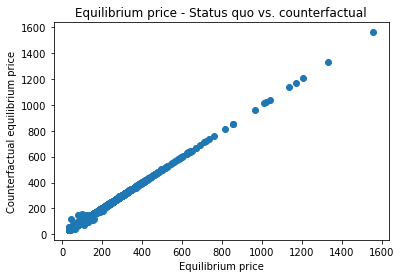

In [575]:
plt.scatter(res["price_ne"],res["price_cf"])
plt.xlabel("Equilibrium price")
plt.ylabel("Counterfactual equilibrium price")
plt.title("Equilibrium price - Status quo vs. counterfactual")

Text(0.5, 1.0, 'Equilibrium market shares - Status quo vs. counterfactual')

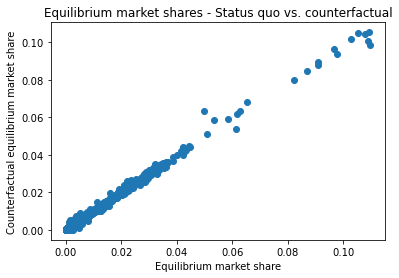

In [576]:
plt.scatter(res["market_share_ne"],res["market_share_cf"])
plt.xlabel("Equilibrium market share")
plt.ylabel("Counterfactual equilibrium market share")
plt.title("Equilibrium market shares - Status quo vs. counterfactual")

In [577]:
df_3["market_share_diff"] = df_3["market_share_cf"] - df_3["market_share_ne"]

NameError: name 'df_3' is not defined

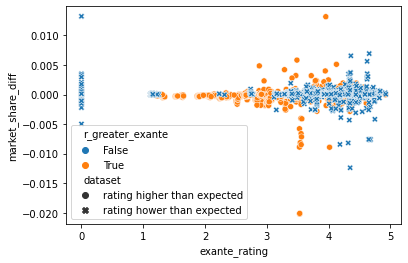

In [226]:
higher_quality  = df_3[df_3["r_greater_exante"]==True]
lower_quality  = df_3[df_3["r_greater_exante"]==False]

concatenated = pd.concat([higher_quality.assign(dataset='rating higher than expected'),\
                          lower_quality.assign(dataset='rating hower than expected')])


sns.scatterplot(x='exante_rating', y='market_share_diff', data=concatenated,
                hue='r_greater_exante', style='dataset')
plt.show()

In [227]:
df_data[df_data["demand_cf"]>df_data["Supply"]]

,index,post_month,shareid,year_month,Supply,Demand,Revenue,Occ,ADR,RevPAR,...,price_cf,delta_cf,D_g_sum_cf,market_share_cf,demand_cf,group_share_cf,market_share_sum_cf,s_0_cf,market_share_cf_delta_diff,price_diff
60,11152,2016-02,410676,2016-02-01,3915.0,3242.0,145410.87,82.8097,44.852212,37.141985,...,44.779135,-2.569689,1.779370,0.002954,3977.190555,0.227275,0.640206,0.359794,-0.000270,-0.032410
14,2068,2016-02,740551,2016-02-01,1856.0,1845.0,272046.00,99.4073,147.450407,146.576509,...,147.377615,-1.877284,2.681615,0.005771,1881.053648,0.268546,0.728380,0.271620,0.000097,-0.887627
22,4684,2016-02,4951378,2016-02-01,2175.0,1994.0,547136.00,91.6781,274.391174,251.556782,...,274.125308,-1.799527,2.681615,0.006773,2207.499967,0.268546,0.728380,0.271620,0.000143,-3.023607


In [578]:
res.to_csv(r"welfare_eq_result_update_baseline.csv",index =False)

In [283]:
df_data = pd.read_csv(r"/Users/juju/Library/Mobile Documents/com~apple~CloudDocs/ta_project/output/welfare/welfare_eq_result_random.csv")

In [579]:
df_data = res

In [580]:
# calculate walfare
df_data["market_share_cf_delta_diff"] = df_data["market_share_cf"]*(rating_param*(df_data["Rating"] - df_data["exante_rating"])+alpha*(df_data["price_ne"]-df_data["price_cf"]))
#df_data["market_share_cf_delta_diff"] = df_data["market_share_cf"]*(df_data["quality"] - df_data["quality_without_review_fixed_price"])



diff = df_data.groupby(["month","year"])["market_share_cf_delta_diff"].sum().reset_index().rename(columns={"market_share_cf_delta_diff":"diff_term"})
temp = df_data.merge(diff,on=["month","year"], how="left")

df_3 = temp
    

In [581]:
df_3["r_greater_exante"] = df_3["exante_rating"]<df_3["Rating"]

df_3["rating_diff_exante"] =  df_3["Rating"]-df_3["exante_rating"]
df_3["market_share_percent_diff"] = (df_3["market_share_cf"] - df_3["market_share"])/df_3["market_share"]



In [582]:
df_cs = df_3[["Market","year","month","Market Monthly Supply","D_g_sum_ne","D_g_sum_cf","diff_term"]].drop_duplicates()

df_cs["cs"] = (np.log(1+df_cs["D_g_sum_ne"]) - np.log(1+df_cs["D_g_sum_cf"])-df_cs["diff_term"])/alpha


avg_rating = df_3.groupby(["Market","year","month"])["Rating"].mean().reset_index()
avg_exante_rating = df_3.groupby(["Market","year","month"])["exante_rating"].mean().reset_index()
avg_diff_rating = df_3.groupby(["Market","year","month"])["rating_diff_exante"].mean().reset_index()
hotel_count = df_3.groupby(["Market","year","month"])["shareid"].nunique().reset_index()
hotel_better_than_exp = df_3[df_3["r_greater_exante"]==1].groupby(["Market","year","month"])["shareid"].nunique().reset_index()
market_share_percent_diff = df_3.groupby(["Market","year","month"])["market_share_percent_diff"].mean().reset_index()

df_cs = df_cs.merge(avg_diff_rating,\
            on=["Market","year","month"]).merge(avg_rating,\
    on=["Market","year","month"]).merge(avg_exante_rating,\
        on=["Market","year","month"]).merge(hotel_count,\
    on=["Market","year","month"]).merge(hotel_better_than_exp,\
        on=["Market","year","month"]).merge(market_share_percent_diff, on=["Market","year","month"])
#df_cs["% better than expected"] = df_cs["shareid_y"]/df_cs["shareid_x"]
df_cs


,Market,year,month,Market Monthly Supply,D_g_sum_ne,D_g_sum_cf,diff_term,cs,rating_diff_exante,Rating,exante_rating,shareid_x,shareid_y,market_share_percent_diff
0,"Chicago, IL",2016,1,1176605.0,0.808273,0.809018,-0.000859,-0.029580,0.000319,4.108866,4.108547,111,50,-0.028175
1,"Chicago, IL",2016,2,1100678.0,0.995903,0.995801,0.000813,0.050440,-0.000233,4.111176,4.111409,111,50,-0.031177
2,"Chicago, IL",2016,3,1175049.0,2.118571,2.111137,0.007778,0.356958,0.000059,4.115304,4.115245,111,48,-0.010838
3,"Chicago, IL",2016,4,1143704.0,2.923324,2.919999,-0.000605,-0.096180,0.000410,4.122978,4.122568,112,47,0.002110
4,"Chicago, IL",2016,5,1180280.0,3.923145,3.918695,-0.003242,-0.274494,-0.000424,4.119146,4.119570,112,49,0.006871
5,"Chicago, IL",2016,6,1154176.0,5.689894,5.684126,0.009362,0.562726,0.000106,4.119566,4.119460,113,52,0.011142
6,"Chicago, IL",2016,7,1195017.0,6.690518,6.690350,0.000930,0.060124,-0.000374,4.116507,4.116882,113,49,0.008497
7,"Chicago, IL",2016,8,1197300.0,4.993102,4.993689,-0.006629,-0.432430,0.000242,4.122746,4.122504,114,49,0.001193
8,"Chicago, IL",2016,9,1165230.0,4.823822,4.810614,0.025498,1.537887,0.000173,4.119634,4.119461,114,52,0.005390
9,"Chicago, IL",2016,10,1210161.0,5.619173,5.609071,0.000960,-0.037577,0.000024,4.118265,4.118241,116,57,0.004186


In [583]:
market_size = df.groupby("Market")["Market Monthly Supply"].max().reset_index().rename(columns={"Market Monthly Supply":"market_size"})

df_cs = df_cs.merge(market_size, on="Market")

df_cs["month_cs"] = df_cs["cs"]*df_cs["market_size"]

df_cs.groupby("Market")["month_cs"].sum()


Market
Chicago, IL         -525504.965906
Houston, TX          -75078.182408
Miami/Hialeah, FL   -322728.465527
Name: month_cs, dtype: float64

In [584]:
market_size = df.groupby("Market")["Market Monthly Supply"].max().reset_index().rename(columns={"Market Monthly Supply":"market_size"})
max_cs = df_cs.groupby("Market")["cs"].max().reset_index().rename(columns={"cs":"max_cs"})
min_cs = df_cs.groupby("Market")["cs"].min().reset_index().rename(columns={"cs":"min_cs"})
mean_cs = df_cs.groupby("Market")["cs"].mean().reset_index().rename(columns={"cs":"mean_cs"})

cs = market_size.merge(max_cs, on="Market").merge(min_cs, on="Market").merge(mean_cs,on="Market")
cs["total_cs"] = cs["market_size"]*cs["mean_cs"]*12/1000000
cs

,Market,market_size,max_cs,min_cs,mean_cs,total_cs
0,"Chicago, IL",1210161.0,1.537887,-2.391222,-0.036187,-0.525505
1,"Houston, TX",1412716.0,0.591977,-0.567271,-0.004429,-0.075078
2,"Miami/Hialeah, FL",319483.0,1.641360,-2.375192,-0.084180,-0.322728


In [289]:
df_cs["cs"].mean()*(1210161+1436018+325923)*12

117907922.99126972

In [290]:
df_3 = df_3.merge(df_cs, on=["Market","year","month","Market Monthly Supply","D_g_sum_ne","D_g_sum_cf","diff_term","market_size"])


In [291]:
# calculate weighted market share percent change

weights = df_3[["Market","shareid","month","capacity"]].drop_duplicates()
market_capacity = weights.groupby(["Market","month"])["capacity"].sum().reset_index().rename(columns={"capacity":"capacity_market"})
weights = weights.merge(market_capacity, on=["Market","month"], how="left")
weights["weights"] = weights["capacity"]/weights["capacity_market"]


In [292]:
df_3 = df_3.merge(weights[["Market","month","shareid","weights"]], on=["Market","month","shareid"], how="left")

In [293]:
#df_3["weights"] = df_3["market_share"]/(1-df_3["s_0"])

In [294]:

df_3["market_share_percent_diff"] = (df_3["market_share_ne"] - df_3["market_share_cf"])/df_3["market_share_cf"]
df_3["market_share_percent_diff_weighted"] =df_3["market_share_percent_diff"]*df_3["weights"]
market_share_change = df_3.groupby(["shareid","Market"])["market_share_percent_diff_weighted"].sum().reset_index()
market_share_change.groupby(["Market"])["market_share_percent_diff_weighted"].mean().reset_index()

,Market,market_share_percent_diff_weighted
0,"Chicago, IL",3.545771e+03
1,"Houston, TX",4.476984e+07
2,"Miami/Hialeah, FL",1.077206e-01


In [295]:

df_3["rating_int"] = df_3["accum_rating"].round(0)
df_3["rating_int"] = df_3["rating_int"].clip(lower=2)
df_3["market_share_diff"] = df_3["market_share_ne"] - df_3["market_share_cf"]
#market_share_change = df_3.groupby(["shareid","rating_int"])["market_share_percent_diff_weighted"].sum().reset_index()
df_3.groupby(["Market","r_greater_exante"])["market_share_percent_diff"].mean().reset_index()

,Market,r_greater_exante,market_share_percent_diff
0,"Chicago, IL",False,1.466934e+06
1,"Chicago, IL",True,4.146544e+03
2,"Houston, TX",False,1.158398e+10
3,"Houston, TX",True,2.844037e-02
4,"Miami/Hialeah, FL",False,5.016160e+00
5,"Miami/Hialeah, FL",True,2.073592e-01


In [242]:
df_3[df_3["market_share_percent_diff"]==df_3["market_share_percent_diff"].max()]["market_share_cf"]

1422    6.448796e-10
Name: market_share_cf, dtype: float64

In [243]:
market_share_sum = df_3[["Market","month","s_0_ne","s_0_cf"]].drop_duplicates()
market_share_sum["s_0_diff"] = market_share_sum["s_0_ne"]-market_share_sum["s_0_cf"]
market_share_sum.groupby("Market")["s_0_diff"].mean()

Market
Chicago, IL         -0.000475
Houston, TX          0.001729
Miami/Hialeah, FL   -0.002576
Name: s_0_diff, dtype: float64

In [117]:
list(df_3.columns)

['index',
 'post_month',
 'shareid',
 'year_month',
 'Supply',
 'Demand',
 'Revenue',
 'Occ',
 'ADR',
 'RevPAR',
 'Country',
 'Market',
 'Chain',
 'Owner',
 'Mgmt',
 'ParentCompany',
 'Operation',
 'Scale',
 'Class',
 'Location',
 'OpenDate',
 'SizeCode',
 'max_str_month',
 'max_review_month',
 'min_review_month',
 'on_ta',
 'monthly_rating_mean',
 'monthly_review_count',
 'monthly_one_star_count',
 'monthly_two_star_count',
 'monthly_three_star_count',
 'monthly_four_star_count',
 'monthly_five_star_count',
 'monthly_hotel_response_count',
 'monthly_partnership_reviews_count',
 'cleanliness_count',
 'cleanliness_mean',
 'location_count',
 'location_mean',
 'sleep_quality_count',
 'sleep_quality_mean',
 'room_quality_count',
 'room_quality_mean',
 'service_count',
 'service_mean',
 'value_count',
 'value_mean',
 'renovate',
 'solo_count',
 'couple_count',
 'family_count',
 'business_count',
 'month_with_reviews',
 'num_of_reviews',
 'total_one_star',
 'total_two_star',
 'total_three_st

In [119]:
df_3["Revenue_cf"] = df_3["market_share_cf"]*df_3["market_size"]*df_3["price_cf"]
df_3["Revenue_ne"] = df_3["market_share_ne"]*df_3["market_size"]*df_3["price_ne"]
df_3["revenue_diff"] = df_3["Revenue_ne"] - df_3["Revenue_cf"]
df_3.groupby("Operation")["revenue_diff"].sum()/1000000

Operation
1   -1.221096
2    6.130465
3    5.707894
Name: revenue_diff, dtype: float64

In [73]:


df_3.groupby(["Market","r_greater_exante"])["revenue_diff"].sum()/1000000
                                        

Market             r_greater_exante
Chicago, IL        False              -22.549999
                   True                27.211447
Houston, TX        False              -14.270697
                   True                23.312428
Miami/Hialeah, FL  False              -14.830033
                   True                21.391790
Name: revenue_diff, dtype: float64

In [74]:
df_3["revenue_percent_diff"] = (df_3["Revenue_ne"] - df_3["Revenue_cf"])/df_3["Revenue_cf"]
df_3.groupby(["Class Group"])["revenue_percent_diff"].mean()

Class Group
economy_group    12645.760447
luxury_group        -0.002839
upscale_group        0.819396
Name: revenue_percent_diff, dtype: float64

In [75]:
df_3["price_percent_diff"] = (df_3["price_ne"] - df_3["price_cf"])/df_3["price_cf"]
df_3.groupby(["Class Group"])["price_diff"].mean()

KeyError: 'Column not found: price_diff'

In [76]:
df_3["price_percent_diff"] = (df_3["price_ne"] - df_3["price_cf"])/df_3["price_cf"]
df_3.groupby(["Class Group","r_greater_exante"])["price_percent_diff"].mean()



Class Group    r_greater_exante
economy_group  False              -0.003851
               True                0.015504
luxury_group   False               0.001522
               True                0.004383
upscale_group  False              -0.002331
               True                0.009301
Name: price_percent_diff, dtype: float64

In [77]:

df_3.groupby(["Class Group"])["market_share_diff"].mean()

Class Group
economy_group    0.000002
luxury_group     0.000034
upscale_group    0.000032
Name: market_share_diff, dtype: float64

In [78]:
df_3.groupby(["Class Group","r_greater_exante"])["market_share_percent_diff"].mean()

Class Group    r_greater_exante
economy_group  False               882469.192561
               True                     0.038015
luxury_group   False                   -0.048300
               True                     0.012355
upscale_group  False                    6.651428
               True                     0.029340
Name: market_share_percent_diff, dtype: float64

In [79]:
upscale = df_3[df_3["Class Group"]=='upscale_group']
luxury["Revenue_ne"]-luxury["Revenue_cf"]

NameError: name 'luxury' is not defined

In [80]:

df_3.groupby(["Operation"])["revenue_percent_diff"].mean()

Operation
1    19740.539662
2        0.238282
3        1.868565
Name: revenue_percent_diff, dtype: float64

In [81]:
df_3.groupby(["Operation"])["market_share_percent_diff"].mean()

Operation
1    357103.448256
2         0.728446
3         4.535914
Name: market_share_percent_diff, dtype: float64

In [895]:
df_3.groupby(["Class Group"])["market_share_percent_diff"].mean()

Class Group
economy_group    3.178861
luxury_group    -0.002716
upscale_group    3.974777
Name: market_share_percent_diff, dtype: float64

In [878]:
df_3["price_diff"] = df_3["price_ne"]-df_3["price_cf"]
df_3.groupby(["Market"])["price_diff"].mean()

Market
Chicago, IL         -0.775220
Houston, TX          0.545473
Miami/Hialeah, FL   -0.012325
Name: price_diff, dtype: float64

In [879]:
df_3.groupby(["Market","r_greater_exante"])["price_diff"].mean()

Market             r_greater_exante
Chicago, IL        False              -1.012713
                   True               -0.184222
Houston, TX        False              -0.145034
                   True                1.476576
Miami/Hialeah, FL  False              -0.227768
                   True                0.415058
Name: price_diff, dtype: float64

In [884]:

df_3.groupby(["rating_int"])["market_share_percent_diff"].mean()

rating_int
2.0    2.950263
3.0    0.005682
4.0    4.500903
5.0    0.017089
Name: market_share_percent_diff, dtype: float64

In [292]:
df_4["price_diff"] = df_4["price_eq_cf"]-df_4["price_eq"]
df_4.groupby(["Market","r_greater_exante"])["price_diff"].mean()

Market             r_greater_exante
Chicago, IL        False               0.082101
                   True                0.064711
Houston, TX        False              -0.094534
                   True               -0.037857
Miami/Hialeah, FL  False              -1.480343
                   True               -1.705819
Name: price_diff, dtype: float64

In [293]:
df_4["delta_diff"] = df_4["delta_cf"] - df_4["delta"]
df_4.groupby(["rating_int"])["delta_diff"].mean()

rating_int
0.0   -0.000377
1.0    0.026756
2.0    0.003004
3.0   -0.004407
4.0   -0.001302
5.0    0.002025
Name: delta_diff, dtype: float64

In [289]:
df_4.groupby(["Market"])["delta_diff"].mean()

Market
Chicago, IL         -0.002225
Houston, TX         -0.004249
Miami/Hialeah, FL    0.017856
Name: delta_diff, dtype: float64

In [300]:

df.groupby(["Market","Operation"])["shareid"].nunique().to_csv(r"market_operation.csv")

In [301]:

df.groupby(["Market","Class"])["shareid"].nunique().to_csv(r"market_class.csv")

In [302]:
df.groupby(["Market","Class"])["shareid"].nunique()

Market             Class
Chicago, IL        1        17
                   2        50
                   3        27
                   4        15
                   5         6
                   6         5
Houston, TX        1         7
                   2        38
                   3        75
                   4        73
                   5        44
                   6        76
Miami/Hialeah, FL  1        22
                   2        25
                   3        18
                   4        10
                   5         9
                   6         4
Name: shareid, dtype: int64

In [303]:
df.groupby(["Market"])["shareid"].nunique()

Market
Chicago, IL          120
Houston, TX          313
Miami/Hialeah, FL     88
Name: shareid, dtype: int64

In [627]:
df_3.to_csv(r"welfare_eq_result.csv", index =False)

,shareid,year_month,Supply,Demand,Revenue,Occ,ADR,RevPAR,Country,Market,...,D_g_sum_cf,market_share_cf,demand_cf,group_share_cf,market_share_sum_cf,s_0_cf,market_share_cf_delta_diff,diff_term,r_greater_exante,cs
0,83062,2016-01-01,7750.0,3445.0,481581.00,44.4516,139.791292,62.139484,United States,"Chicago, IL",...,0.675046,0.003362,4068.830465,0.058749,0.403001,0.596999,0.000023,-0.000820,True,-1.556186
1,88362,2016-01-01,10509.0,4055.0,1248453.00,38.5859,307.879901,118.798458,United States,"Chicago, IL",...,0.675046,0.002664,3223.504967,0.058749,0.403001,0.596999,0.000064,-0.000820,False,-1.556186
2,89959,2016-01-01,1240.0,817.0,202265.00,65.8870,247.570379,163.116935,United States,"Chicago, IL",...,0.675046,0.000870,1053.264639,0.058749,0.403001,0.596999,0.000015,-0.000820,True,-1.556186
3,94226,2016-01-01,5859.0,2274.0,743277.99,38.8120,326.859274,126.860896,United States,"Chicago, IL",...,0.675046,0.001339,1620.469895,0.058749,0.403001,0.596999,0.000055,-0.000820,False,-1.556186
4,105904,2016-01-01,18910.0,11718.0,2227185.00,61.9672,190.065284,117.778160,United States,"Chicago, IL",...,0.675046,0.007292,8824.084667,0.058749,0.403001,0.596999,0.000218,-0.000820,False,-1.556186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5618,3801491,2016-12-01,7750.0,6741.0,2133221.00,86.9806,316.454680,275.254323,United States,"Miami/Hialeah, FL",...,2.161487,0.021004,6845.665569,0.384134,0.683693,0.316307,-0.000115,-0.012126,False,-0.798074
5619,4355335,2016-12-01,44640.0,27203.0,12391941.00,60.9386,455.535823,277.597245,United States,"Miami/Hialeah, FL",...,2.161487,0.085086,27731.453623,0.384134,0.683693,0.316307,-0.002551,-0.012126,True,-0.798074
5620,5735666,2016-12-01,24490.0,19279.0,6602489.00,78.7219,342.470512,269.599388,United States,"Miami/Hialeah, FL",...,2.161487,0.047035,15329.761368,0.384134,0.683693,0.316307,0.004302,-0.012126,True,-0.798074
5621,7325223,2016-12-01,9114.0,7371.0,4662351.00,80.8755,632.526252,511.559250,United States,"Miami/Hialeah, FL",...,2.161487,0.022091,7199.801378,0.384134,0.683693,0.316307,0.000405,-0.012126,False,-0.798074
